In [1]:
import numpy as np
from CT import *
import matplotlib.pyplot as plt

In [32]:
def run_quantum(inputs):
    L,p_ctrl,p_proj,xj,idx=inputs
    # ct=CT_quantum(L=L,x0=None,seed=idx,history=False,xj=xj)
    ct=CT_quantum(L=L,seed=idx,ancilla=False,store_vec=False,store_op=False,store_prob=False,normalization=True,xj=xj)
    # for ii in range(100):
    for _ in range(2*ct.L**2):
        ct.random_control(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.half_system_entanglement_entropy()
    TMI=ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+(ct.L//4)*2,selfaverage=False)

    return O,SA, TMI

In [3]:
def run_quantum_anc(inputs):
    L,p_ctrl,p_proj,xj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=False,ancilla=True,xj=xj)
    # for ii in range(100):
    for _ in range(ct.L**2//2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.von_Neumann_entropy_pure([ct.L])
    return O,SA

In [4]:
def run_quantum_thermalization(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=True)
    SA_list=[]
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
        SA=ct.half_system_entanglement_entropy()
        SA_list.append(SA)
    # O=ct.order_parameter()
    return np.array(SA_list)
    # return ct

In [ ]:
def rescale(x,alpha):
    '''rescale the granularity near (a+b)/2, where a, b are boundary of the range x '''
    a,b=min(x),max(x)
    x1=(x-a)*2/(b-a)-1
    y1=np.sign(x1)*np.abs(x1)**alpha
    return (y1+1)*(b-a)/2+a

In [75]:
def run_xeb(inputs):
    def prob_log(CT):
        if len(CT.prob_history)>0:
            return np.log(np.hstack(CT.prob_history)).sum()
        else:
            return 0
    L,p_ctrl,p_proj,seed_C,seed=inputs
    ct_q=CT_quantum(L=L,seed=seed,seed_vec=0,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
    for _ in range(2*ct_q.L**2):
        ct_q.random_control(p_ctrl, p_proj)
    ct_r=CT_quantum(L=L,seed=seed,seed_vec=1,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
    ct_r.reference_control(ct_q.op_history)
    ct_r_=CT_quantum(L=L,seed=seed,seed_vec=1,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
    for _ in range(2*ct_q.L**2):
        ct_r_.random_control(p_ctrl, p_proj)
    return prob_log(CT=ct_q),prob_log(CT=ct_r),prob_log(CT=ct_r_)

In [ ]:
# ipcluster start --engines=MPI

In [6]:
from ipyparallel import Client
client = Client()

In [7]:
dview = client[:]

In [8]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

## p_ctrol=1, sweep L

In [7]:
L_list=np.array([6,8,10,12,14,16])
# p_ctrl_list=np.linspace(.0,1,11)
# p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,1,0,idx) for L in L_list for idx in range(ensemble)]

## fix p_proj, sweep p_ctrol for different L

In [68]:
L_list=np.array([12,16])
p_ctrl_list=np.linspace(0,1,11)
# p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,p_ctrl,0,set([Fraction(1,3),Fraction(-1,3)]),idx) for L in L_list for p_ctrl in p_ctrl_list for idx in range(ensemble)]

## sweep p_proj, sweep p_ctrol for different L

In [56]:
L_list=np.array([10,12,])
p_ctrl_list=np.linspace(0.,1,21)
# p_ctrl_list=rescale(p_ctrl_list, 2)
p_proj_list=np.linspace(0,1,21)
ensemble=100
# inputs=[(L,p_ctrl,p_proj,[Fraction(1,3),Fraction(2,3)],idx) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for idx in range(ensemble)]
inputs_2=[(L,p_ctrl,p_proj,[0],idx) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for idx in range(ensemble)]

## Everything fixed to check thermalization time

In [87]:
ensemble=10000
inputs=[(12,0.5,0,idx) for idx in range(ensemble)]

## parallel run

In [69]:
results = dview.map_async(run_quantum, inputs)
# results_2 = dview.map_async(run_quantum, inputs_2)
# results = dview.map_async(run_quantum_thermalization, inputs)
# results = dview.map_async(run_xeb, inputs)

In [70]:
len(inputs)
# len(inputs_2)

44000

In [71]:
results.progress
# results_2.progress

0

In [72]:
results.elapsed

16.496896

In [289]:
results.elapsed/results.progress*len(inputs)

2287.469556

## p_ctrol=1, sweep L

In [18]:
rs=np.array(list(results)).reshape((L_list.shape[0],ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

Text(0, 0.5, '$\\overline{\\langle O \\rangle}$')

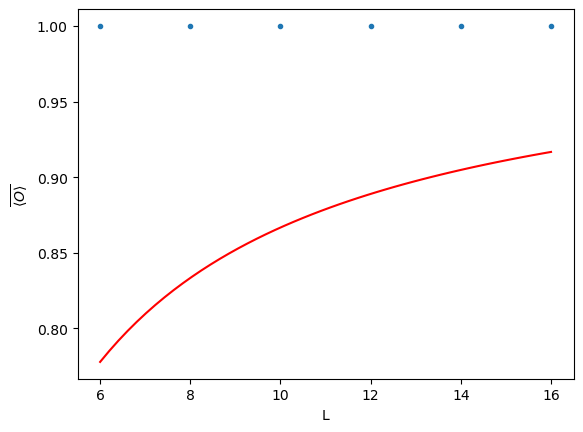

In [19]:
fig,ax=plt.subplots()
ax.plot(L_list,O_map.mean(axis=-1),'.')
L_list_cont=np.linspace(6,16)
ax.plot(L_list_cont,1-4/(3*(L_list_cont)),color='r',label='')
ax.set_xlabel('L')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')

## p_proj=0, sweep p_ctrol for different L

In [73]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],ensemble,3))

In [74]:
O_map,EE_map,TMI_map=rs[:,:,:,0],rs[:,:,:,1],rs[:,:,:,2]

In [75]:
O_map.shape

(2, 11, 2000)

(0.0, 1.0)

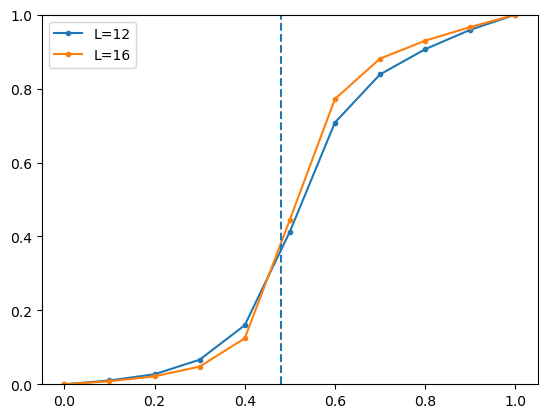

In [79]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed')
# ax.axhline(y=0.5)
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

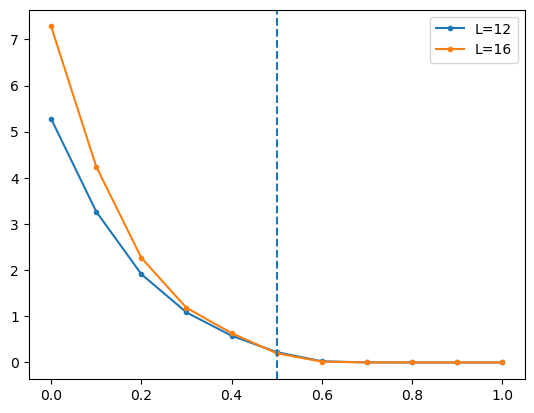

In [77]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.5,ls='dashed')
# ax.set_xlim([.2,.8])
# ax.set_ylim([0,1])

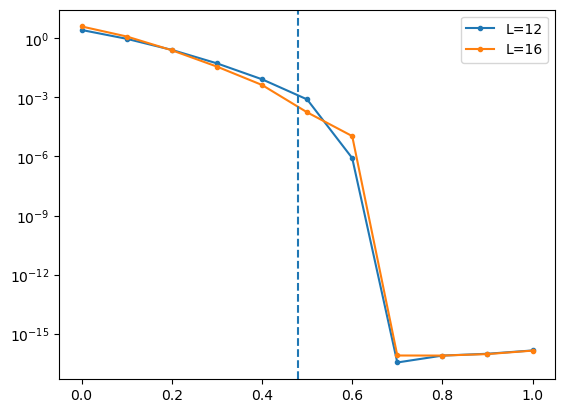

In [81]:
fig,ax=plt.subplots()
for i in range(TMI_map.shape[0]):
    ax.plot(p_ctrl_list,-TMI_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed')
ax.set_yscale('log')
# ax.axhline(y=0.5)
# ax.set_xlim([.2,.8])
# ax.set_ylim([0,1])

## sweep p_proj, sweep p_ctrol for different L

In [52]:
rs=np.array(list(results_2)).reshape((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0],ensemble,3))

In [30]:
O_map,EE_map=rs[:,:,:,:,0],rs[:,:,:,:,1]

Text(0.5, 0, '$p_{ctrl}$')

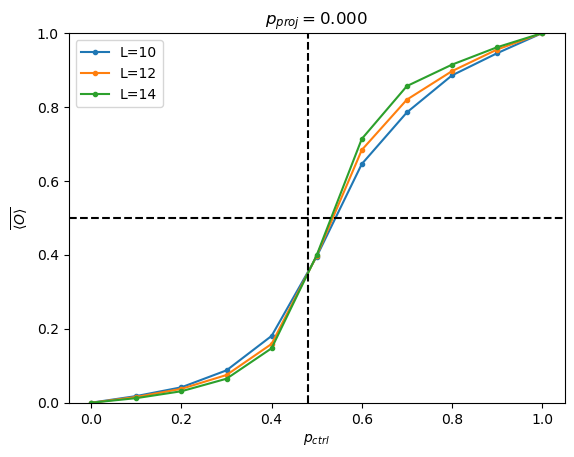

In [86]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

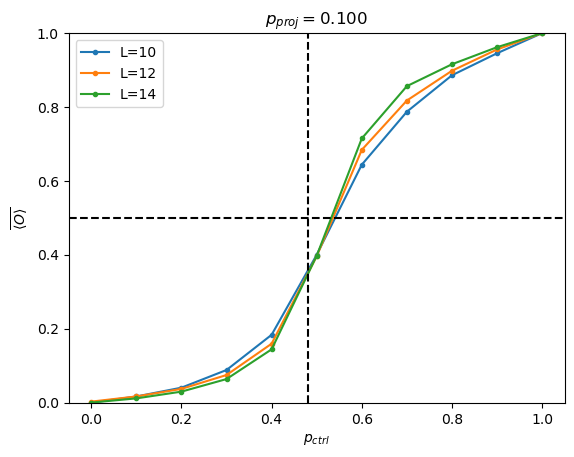

In [87]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

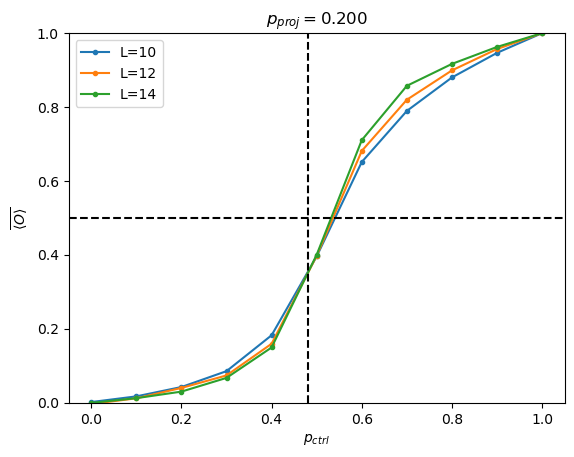

In [88]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

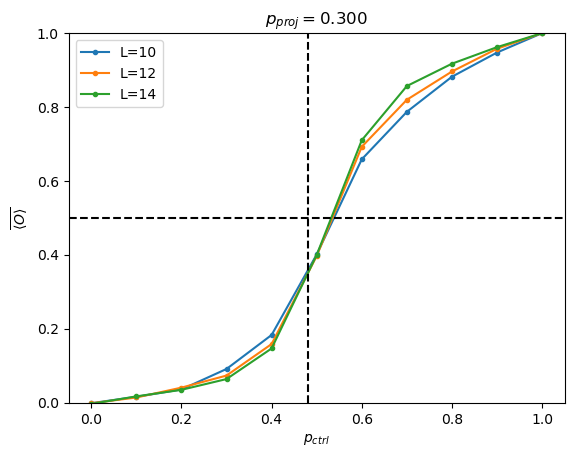

In [89]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

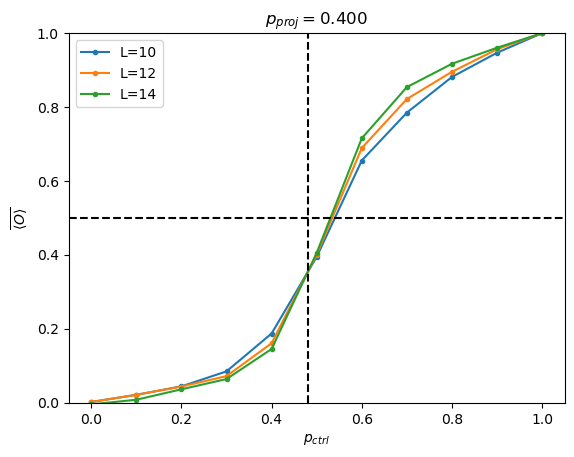

In [90]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

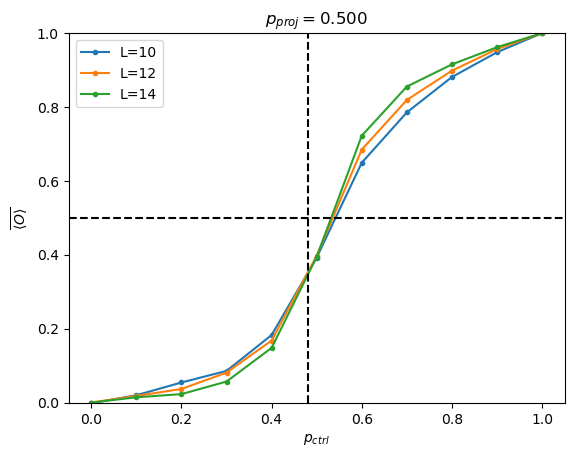

In [91]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

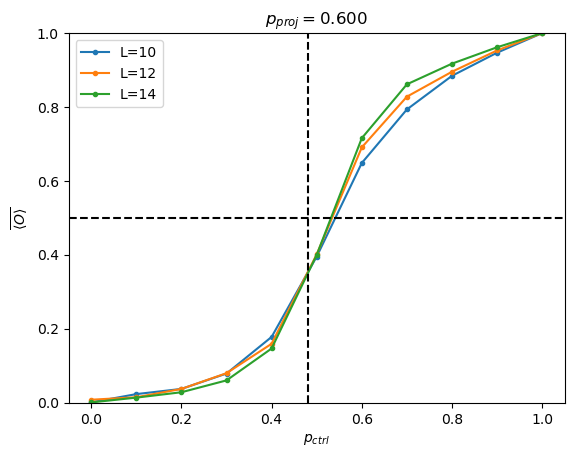

In [92]:
fig,ax=plt.subplots()
p_proj_idx=6
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

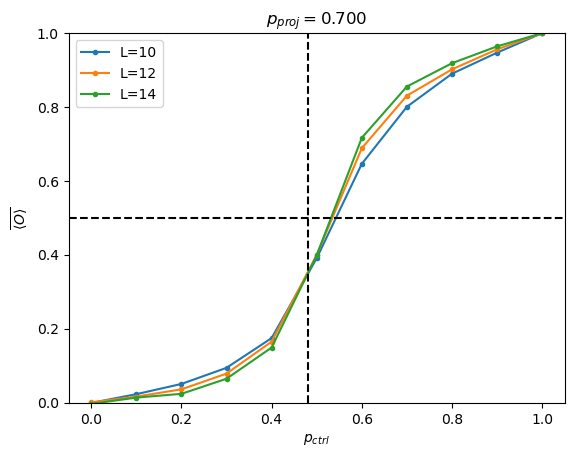

In [93]:
fig,ax=plt.subplots()
p_proj_idx=7
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

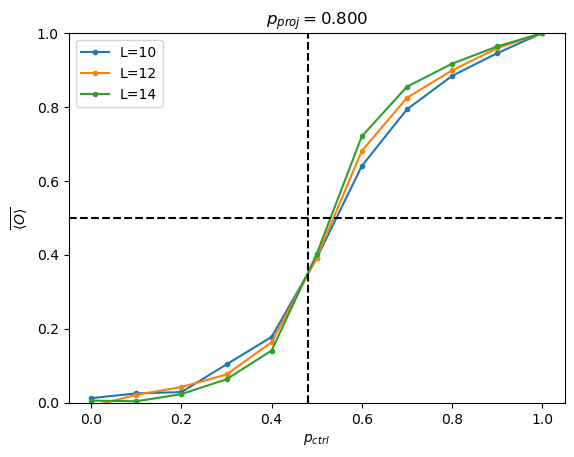

In [94]:
fig,ax=plt.subplots()
p_proj_idx=8
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

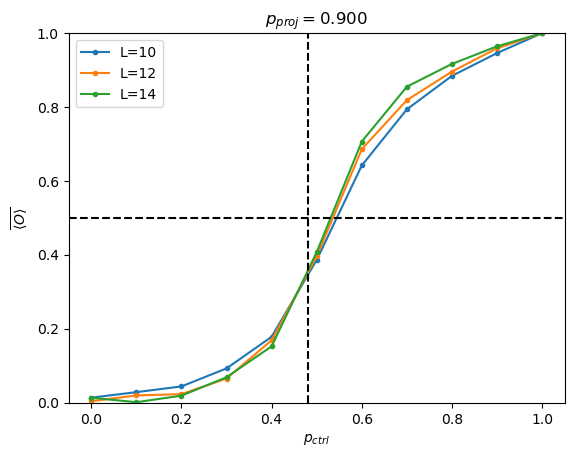

In [85]:
fig,ax=plt.subplots()
p_proj_idx=9
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

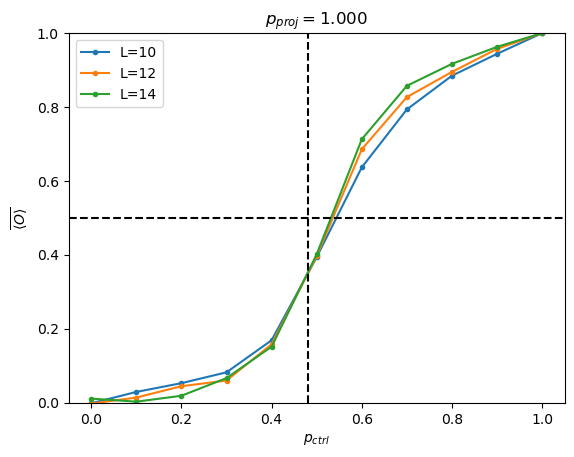

In [84]:
fig,ax=plt.subplots()
p_proj_idx=10
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

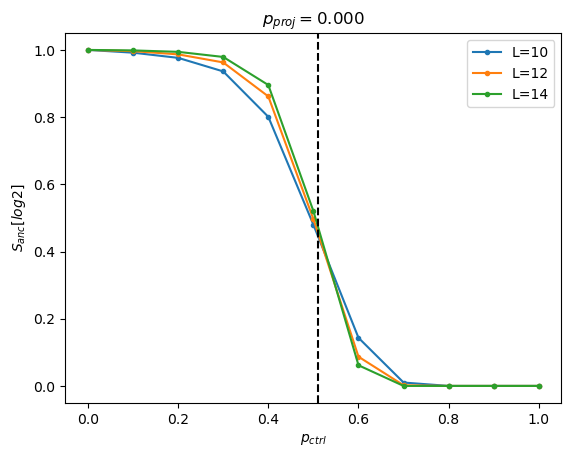

In [44]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

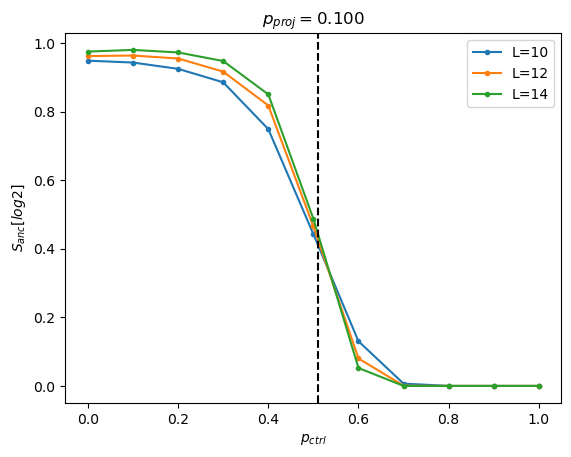

In [45]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

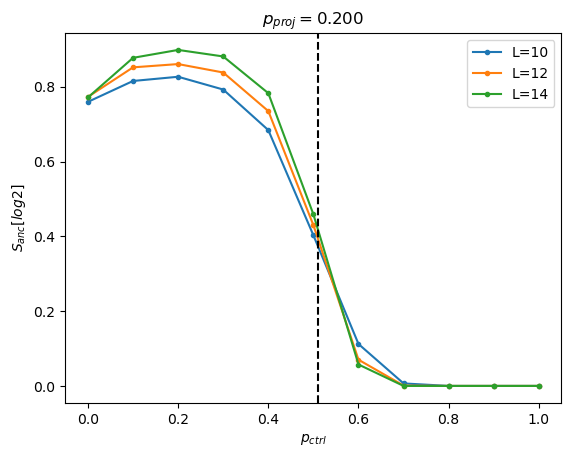

In [46]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

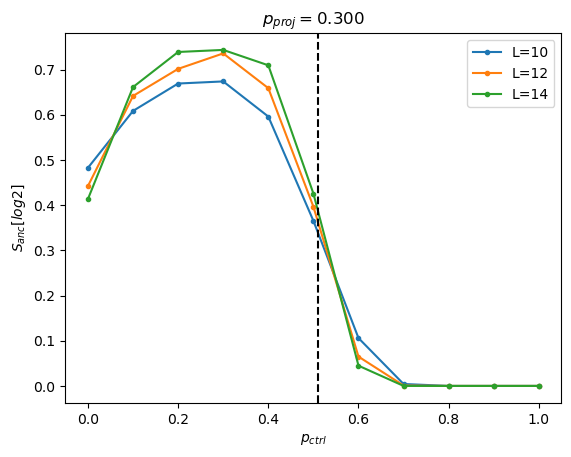

In [47]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

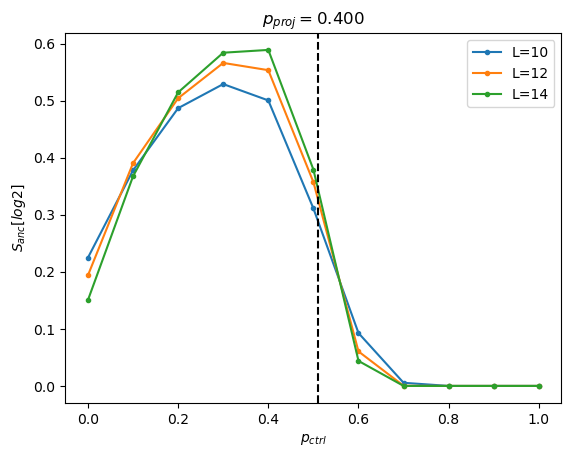

In [48]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

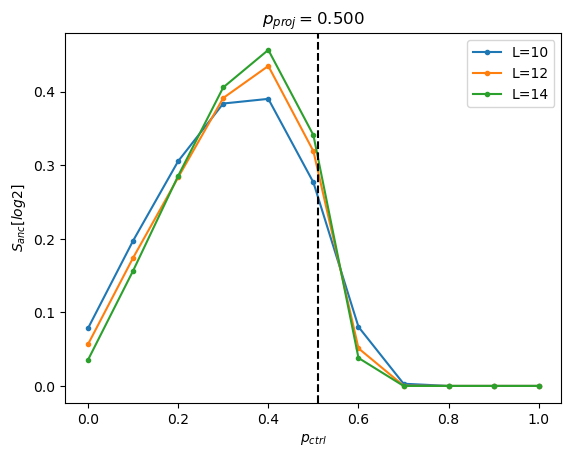

In [49]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

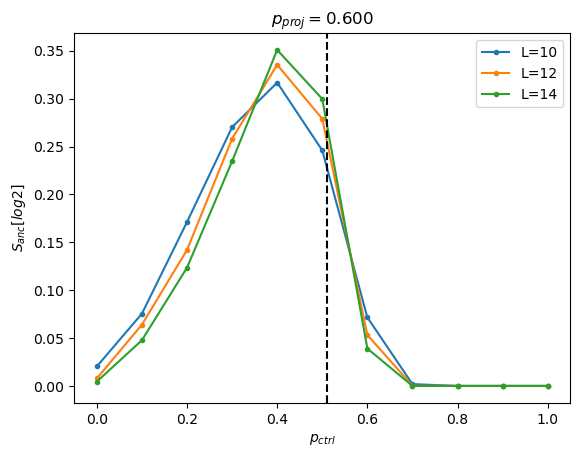

In [50]:
fig,ax=plt.subplots()
p_proj_idx=6
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

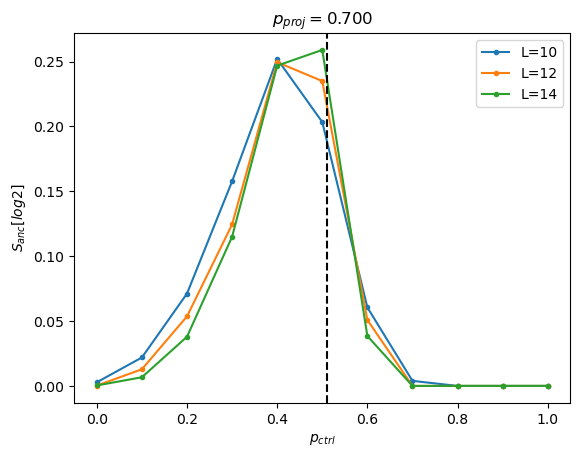

In [51]:
fig,ax=plt.subplots()
p_proj_idx=7
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

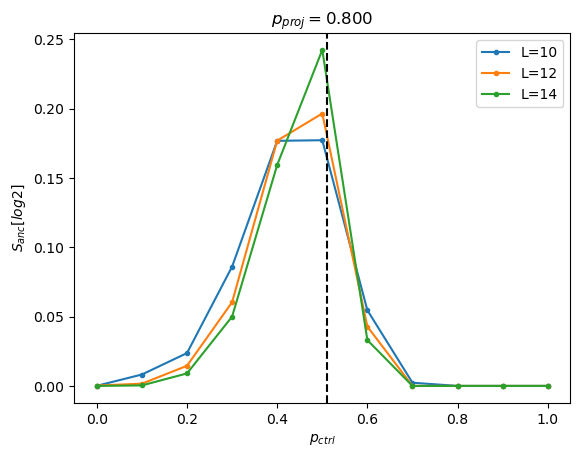

In [52]:
fig,ax=plt.subplots()
p_proj_idx=8
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

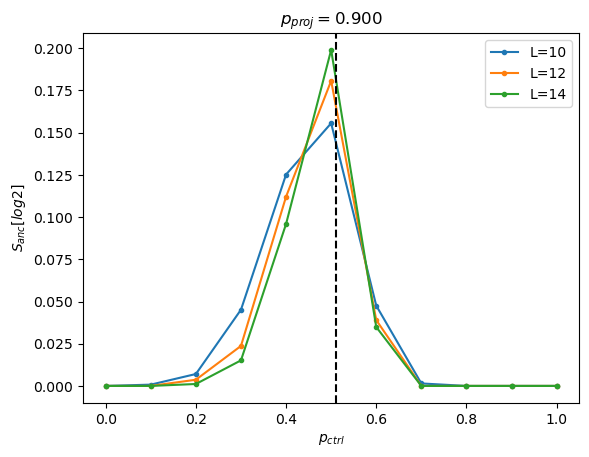

In [53]:
fig,ax=plt.subplots()
p_proj_idx=9
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

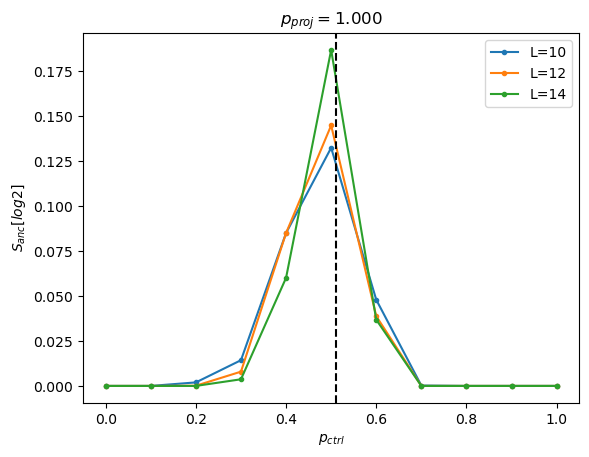

In [54]:
fig,ax=plt.subplots()
p_proj_idx=10
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

In [54]:
rs_2=np.array(list(results_2)).reshape((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0],ensemble,3))

In [55]:
O_map_2,EE_map_2,TMI_map_2=rs_2[:,:,:,:,0],rs_2[:,:,:,:,1],rs_2[:,:,:,:,2]

Text(0.5, 0, '$p_{ctrl}$')

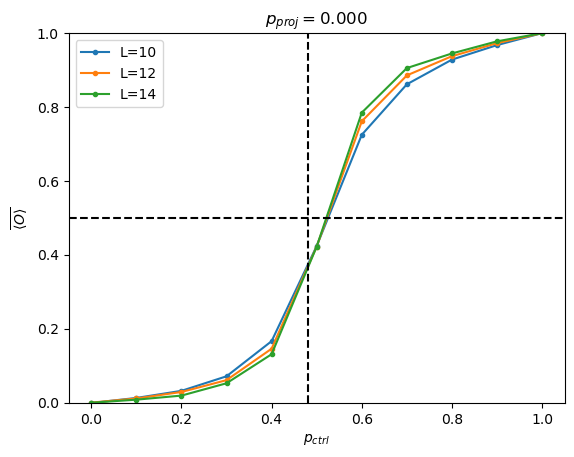

In [106]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

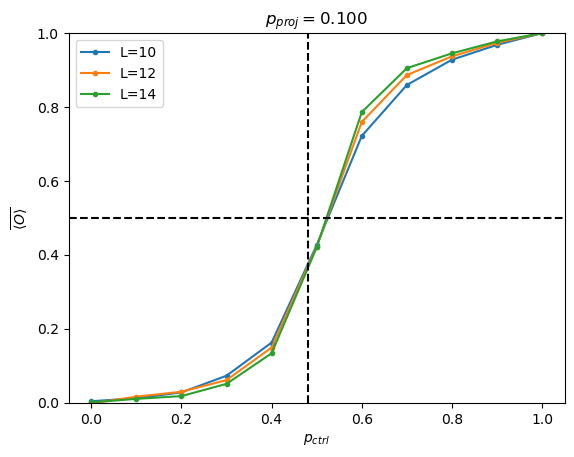

In [119]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

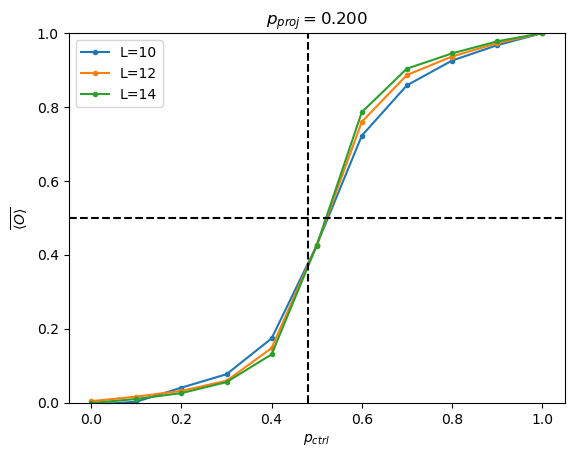

In [120]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

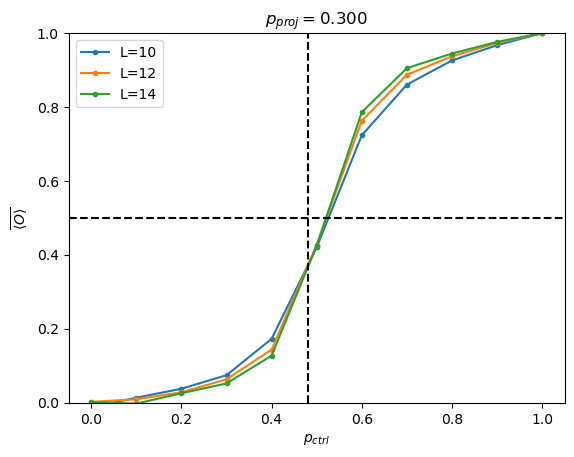

In [121]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

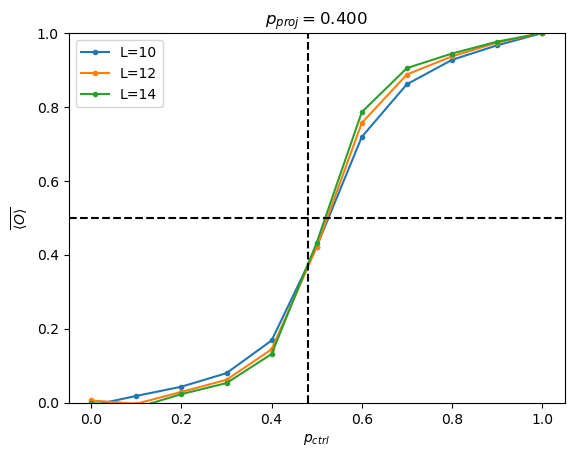

In [122]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

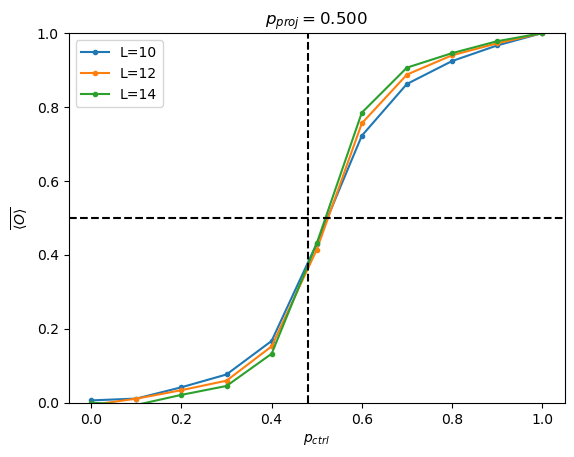

In [123]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

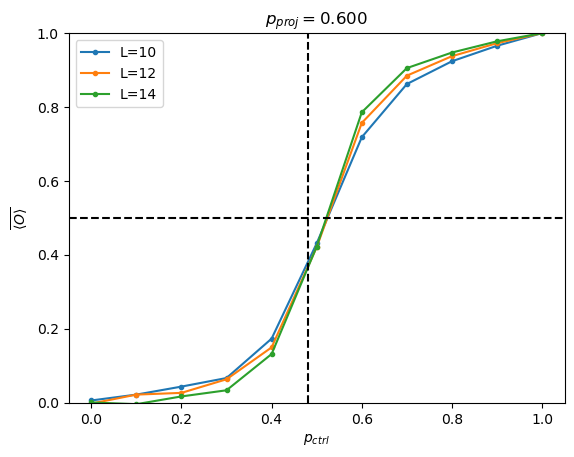

In [124]:
fig,ax=plt.subplots()
p_proj_idx=6
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

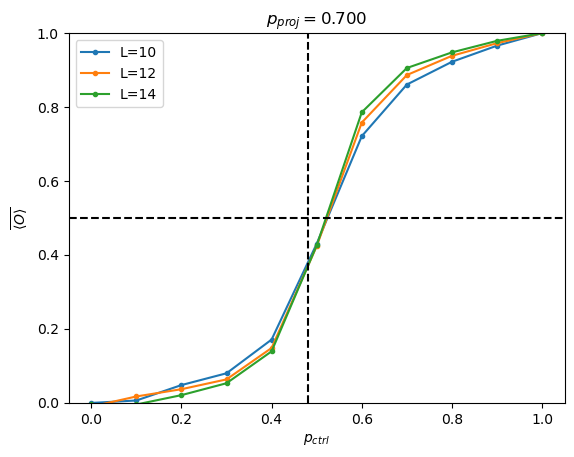

In [125]:
fig,ax=plt.subplots()
p_proj_idx=7
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

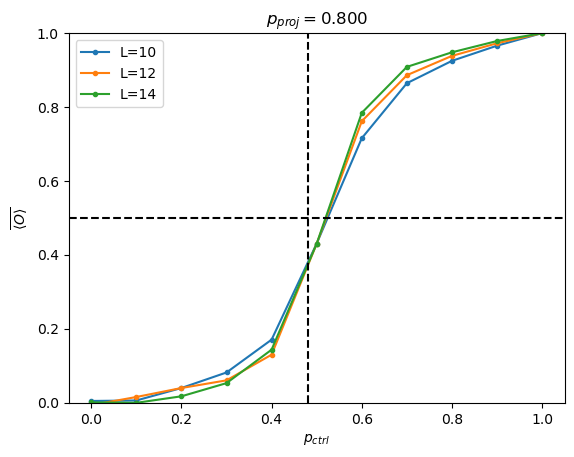

In [126]:
fig,ax=plt.subplots()
p_proj_idx=8
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

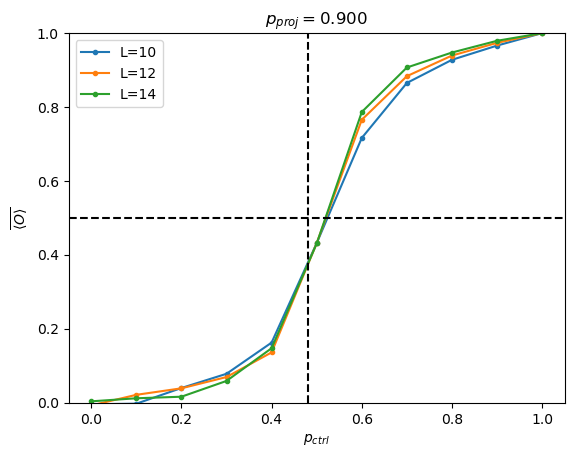

In [127]:
fig,ax=plt.subplots()
p_proj_idx=9
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

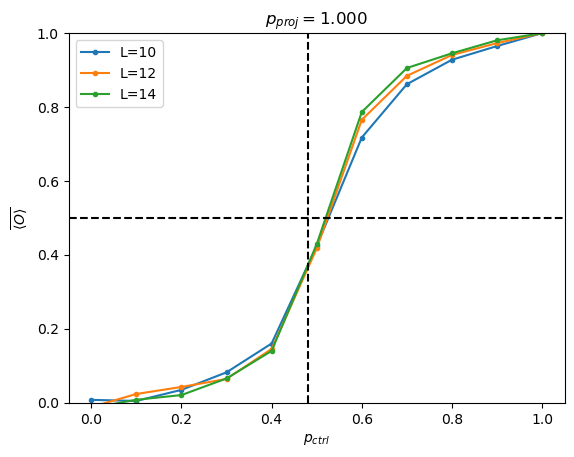

In [128]:
fig,ax=plt.subplots()
p_proj_idx=10
for i in range(O_map_2.shape[0]):
    ax.plot(p_ctrl_list,O_map_2[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

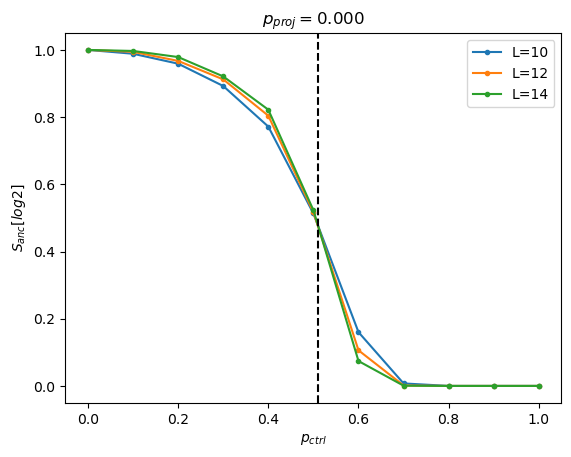

In [107]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

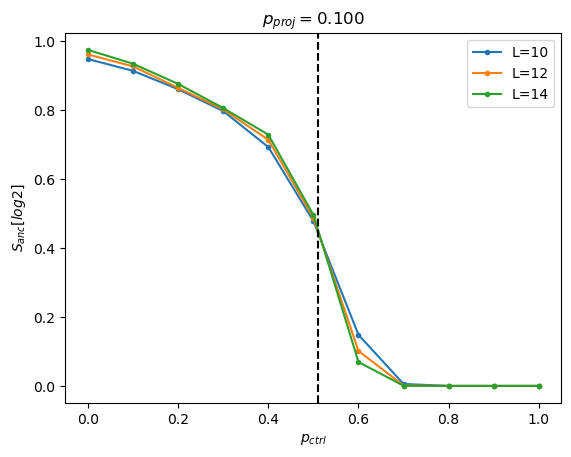

In [108]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

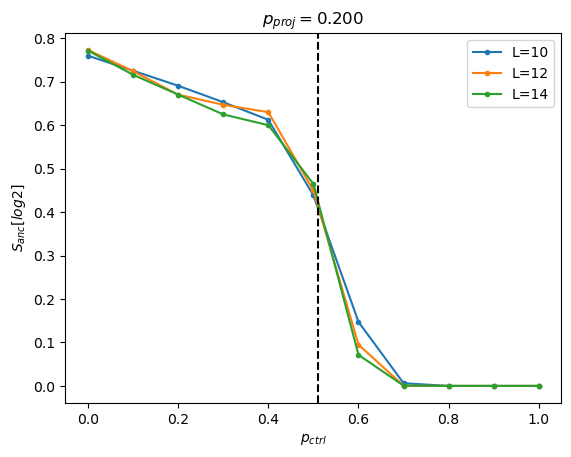

In [109]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

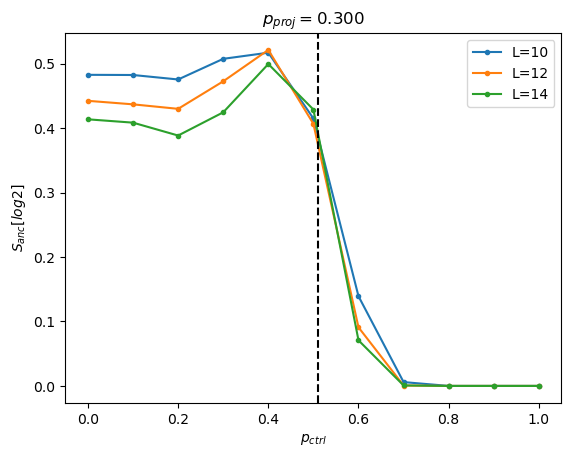

In [111]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

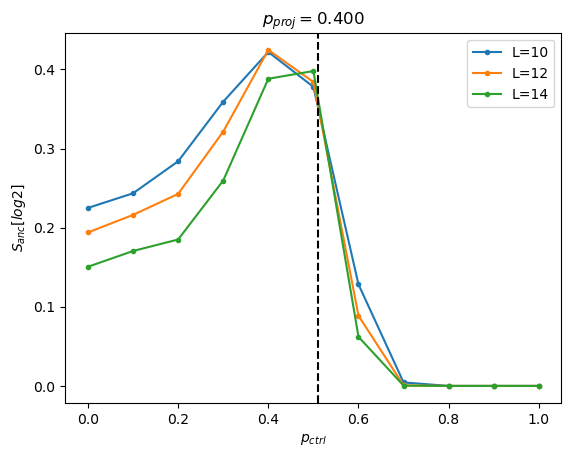

In [112]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

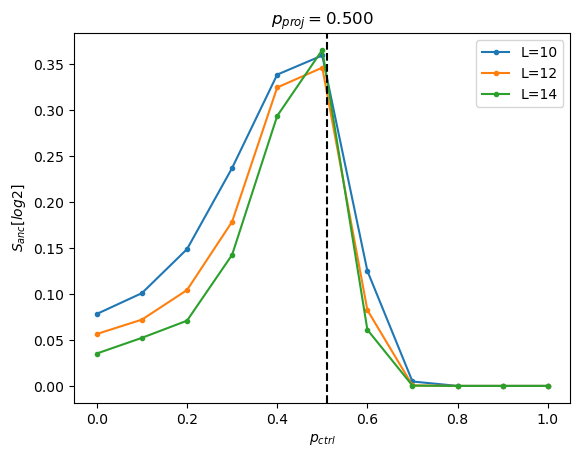

In [113]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

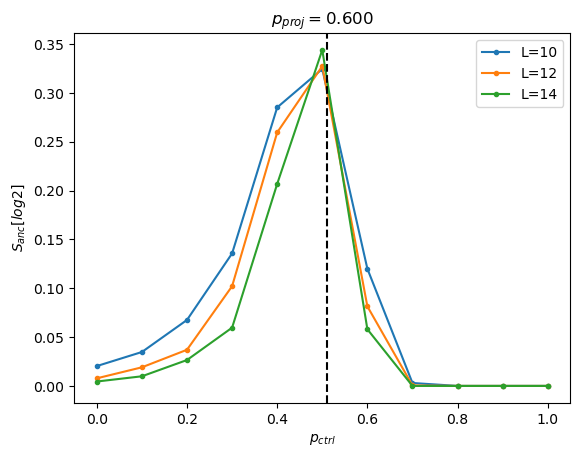

In [114]:
fig,ax=plt.subplots()
p_proj_idx=6
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

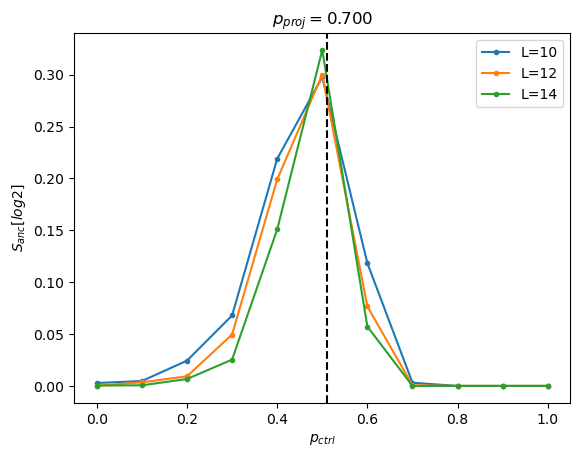

In [115]:
fig,ax=plt.subplots()
p_proj_idx=7
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

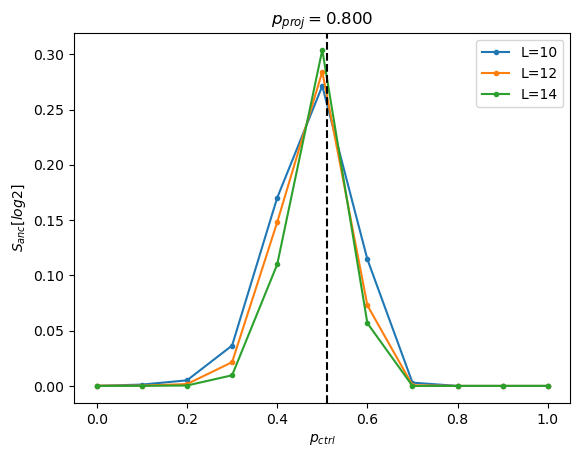

In [116]:
fig,ax=plt.subplots()
p_proj_idx=8
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

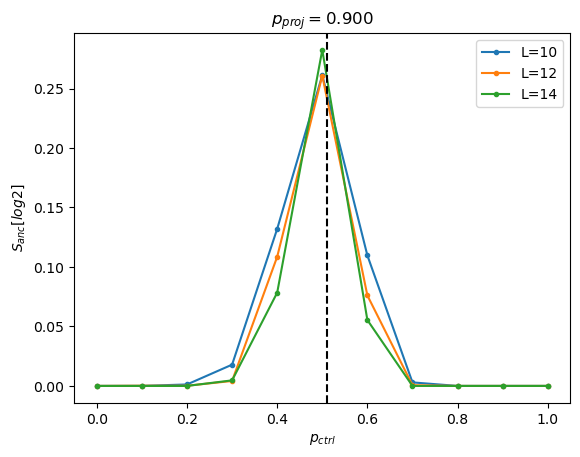

In [117]:
fig,ax=plt.subplots()
p_proj_idx=9
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

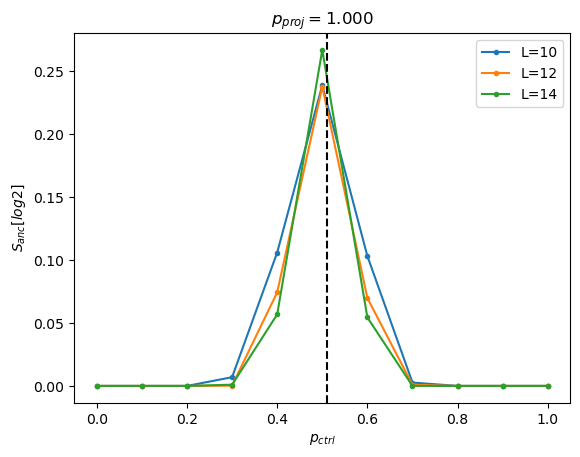

In [118]:
fig,ax=plt.subplots()
p_proj_idx=10
for i in range(EE_map_2.shape[0]):
    ax.plot(p_ctrl_list,EE_map_2[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel('$S_{anc} [log 2]$')
ax.set_xlabel('$p_{ctrl}$')

Text(0.5, 1.0, '$p_{proj}=0.000$')

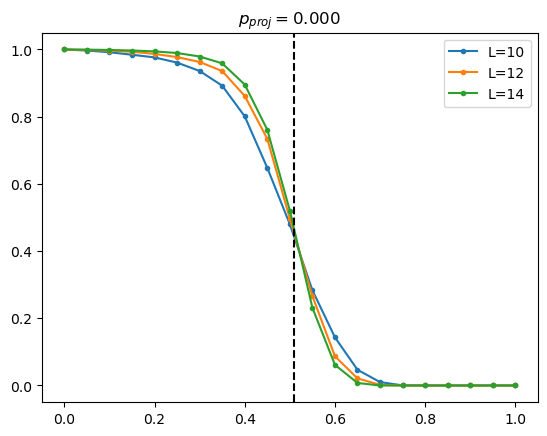

In [90]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

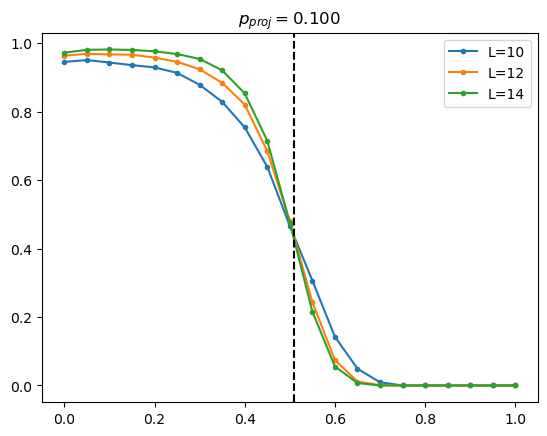

In [91]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

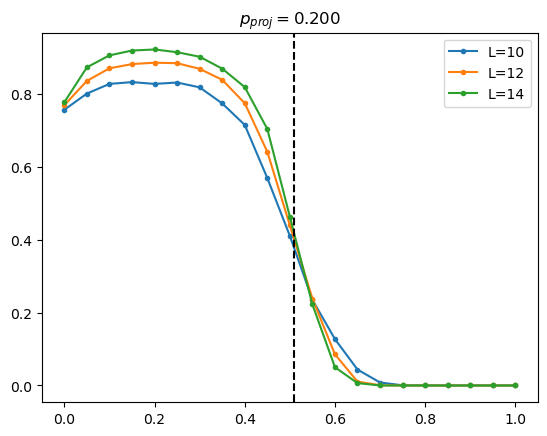

In [92]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

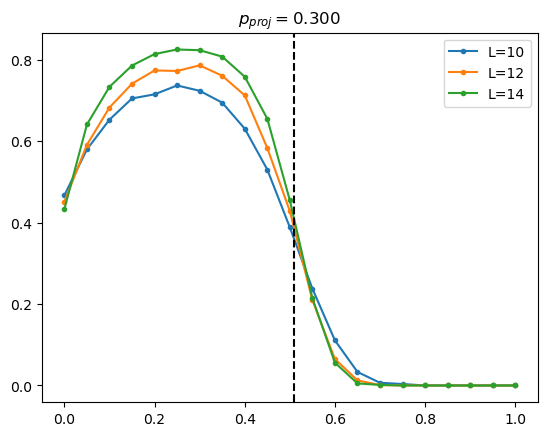

In [93]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

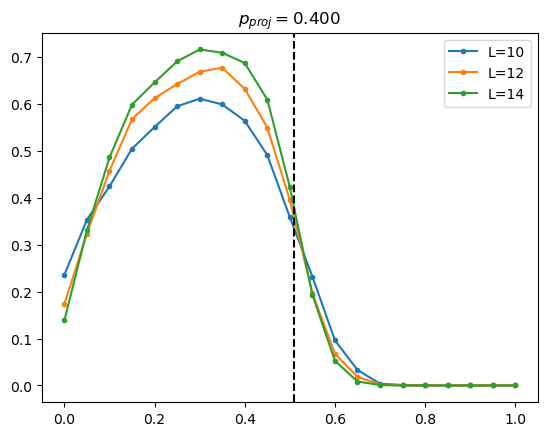

In [94]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

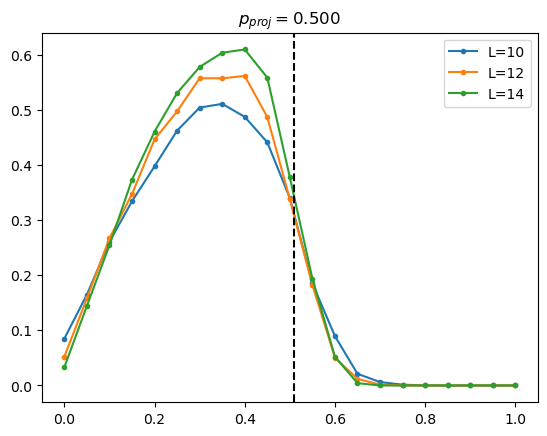

In [95]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

### S_L/2

Text(0.5, 1.0, '$p_{proj}=0.000$')

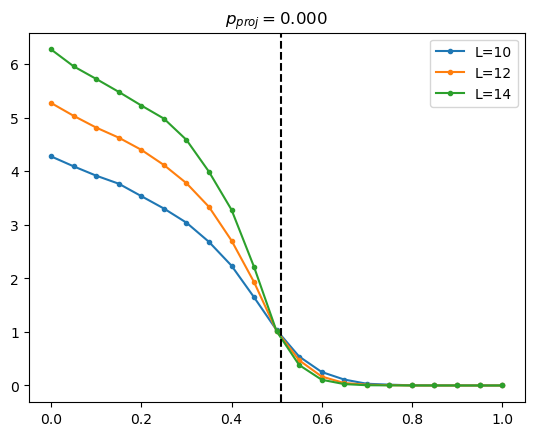

In [36]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

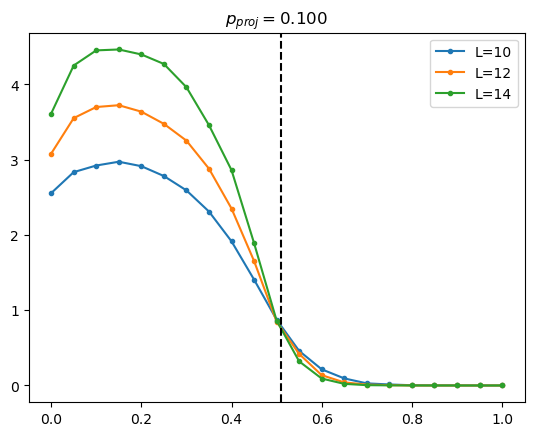

In [35]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

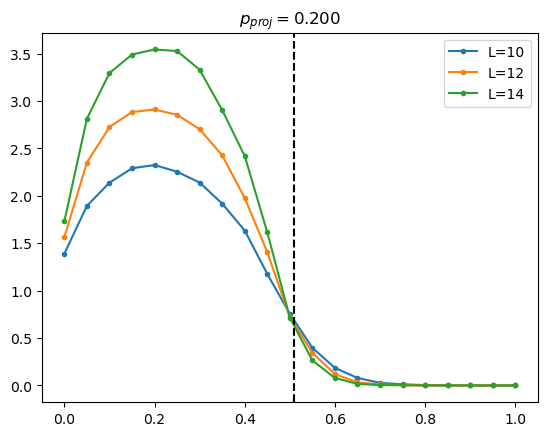

In [37]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

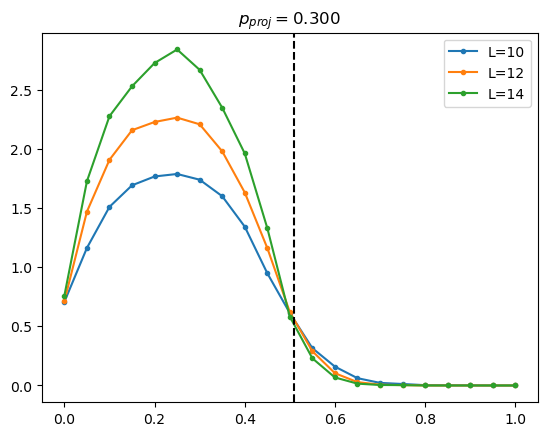

In [38]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

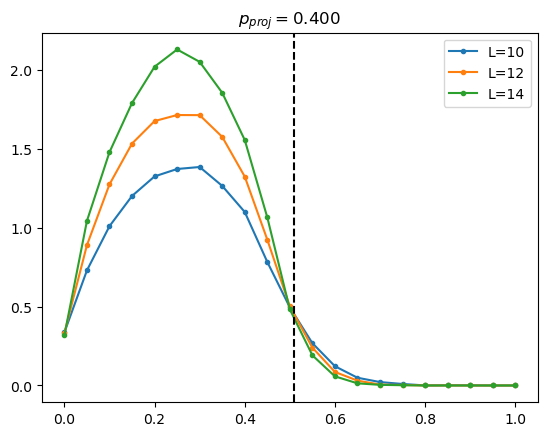

In [39]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

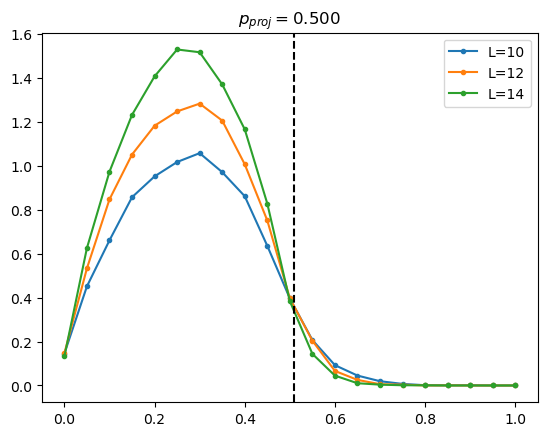

In [40]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

### S_L/2

Text(0.5, 1.0, '$p_{proj}=0.000$')

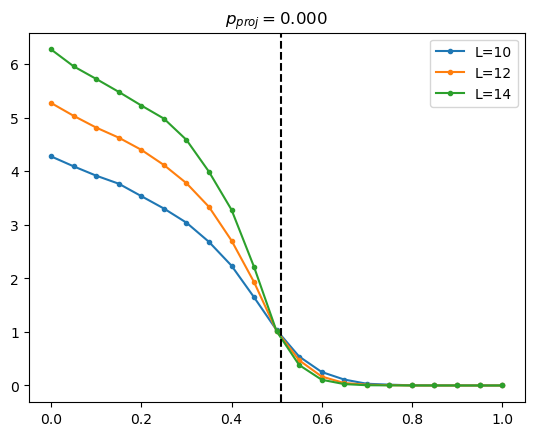

In [67]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

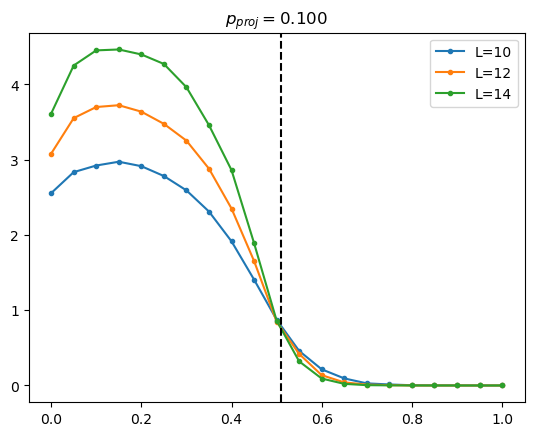

In [68]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

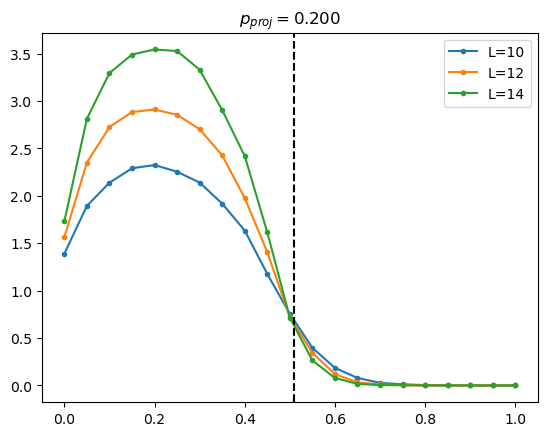

In [69]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

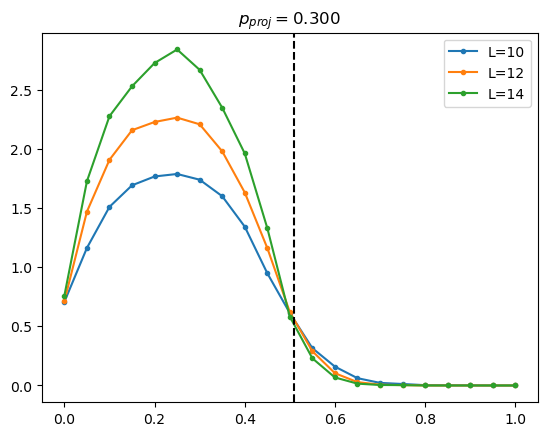

In [70]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

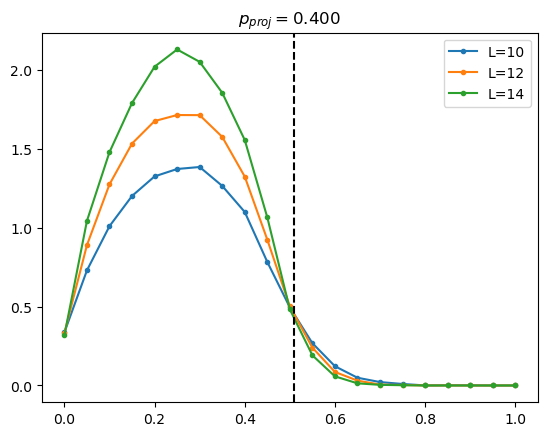

In [71]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

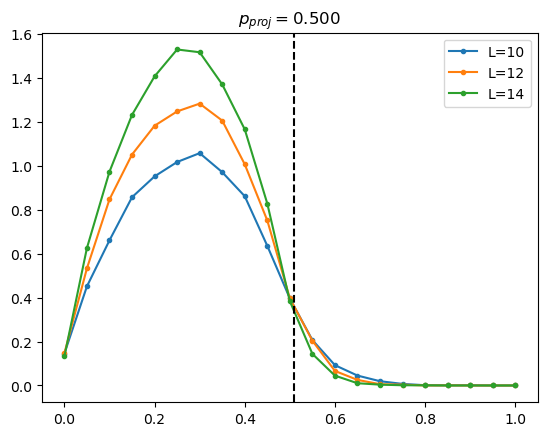

In [72]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

In [91]:
p_ctrl_map,p_proj_map=np.meshgrid(p_ctrl_list,p_proj_list)

In [92]:
proj_map=(1-p_ctrl_map)*p_proj_map+p_ctrl_map

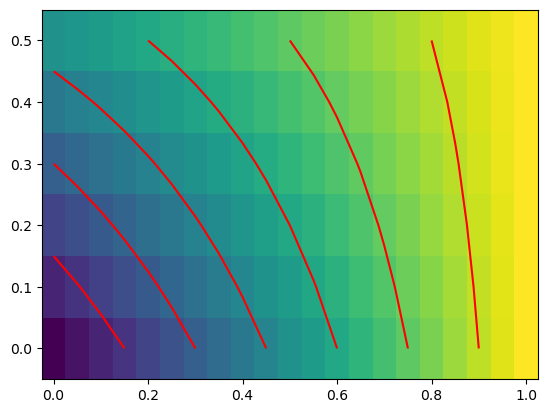

In [97]:
fig,ax=plt.subplots()
ax.pcolormesh(p_ctrl_list,p_proj_list,proj_map,shading='auto')
ax.contour(p_ctrl_list,p_proj_list,proj_map,colors='r')

## Everything fixed to check thermalization time

In [99]:
SA=np.array(list(results))

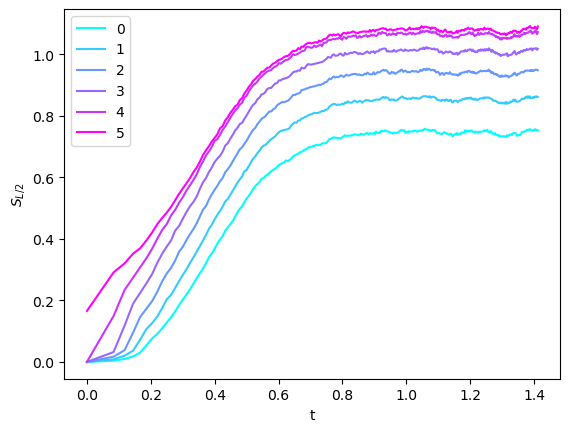

In [101]:
fig,ax=plt.subplots()
L=12
t_list=np.arange(2*L**2)
t_list=np.sqrt(t_list/L**2)

cmap = plt.get_cmap('cool')
cmap_discretized=[cmap(i) for i in np.linspace(0, 1, L//2)]
for idx in range(L//2):
    ax.plot(t_list,SA.mean(axis=0)[:,idx],label=f'{idx}',color=cmap_discretized[idx])
ax.set_ylabel('$S_{L/2}$')
ax.set_xlabel('t')
ax.legend()

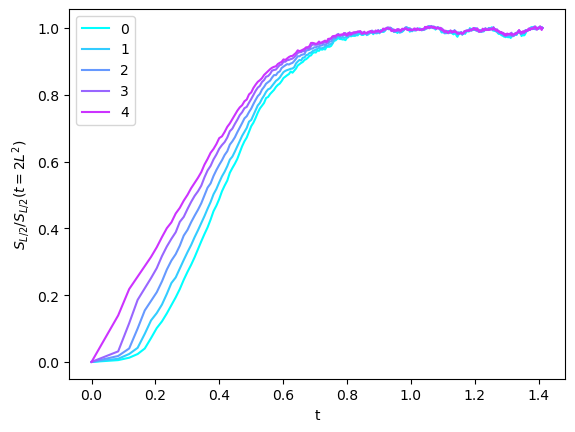

In [103]:
fig,ax=plt.subplots()
for idx in range(5):
    ax.plot(t_list,SA.mean(axis=0)[:,idx]/SA.mean(axis=0)[-1,idx],label=f'{idx}',color=cmap_discretized[idx])

ax.set_ylabel('$S_{L/2}/S_{L/2}(t=2L^2)$')
ax.set_xlabel('t')
ax.legend()
# ax.set_yscale('log')
# ax.set_ylim([0,1])
# ax.set_xlim([70,90])

In [ ]:
rs=np.array(list(results)).reshape((L_list.shape[0],ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

In [ ]:
rs=np.array(list(results)).reshape((ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

# Legacy

## Cross entropy benchmark

In [ ]:
# This may take 1h to run, run it later
seed_C_list=np.arange(0,150)
seed_list=np.arange(0,3200)
L_list=np.array([8,10])
p_ctrl_list=np.array([0])
p_proj_list=np.linspace(0,0.4,5)

In [ ]:
seed_C_list=np.arange(0,30)
seed_list=np.arange(0,3200)
L_list=np.array([8,10,12])
p_ctrl_list=np.array([0])
p_proj_list=np.linspace(0.1,0.25,11)
inputs=[(L,p_ctrl,p_proj,seed_C,seed) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for seed_C in seed_C_list for seed in seed_list]

In [ ]:
# seed_C_list=np.arange(0,30)

seed_list=np.arange(0,3200)
L_list=np.array([8,10,])
p_ctrl_list=np.array([0])
p_proj_list=np.linspace(0.1,0.25,11)
inputs=[(L,p_ctrl,p_proj,seed_C,seed) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for seed_C in np.arange(0,int(4*((L/L_list[0])*(p_proj/p_proj_list[0]))**4)) for seed in seed_list]

In [ ]:
import pandas as pd

In [ ]:
inputs_index=pd.MultiIndex.from_tuples(inputs,names=['L','p_ctrl','p_proj','seed_C','seed'])

In [ ]:
inputs_index

MultiIndex([( 8, 0,  0.1,   0,    0),
            ( 8, 0,  0.1,   0,    1),
            ( 8, 0,  0.1,   0,    2),
            ( 8, 0,  0.1,   0,    3),
            ( 8, 0,  0.1,   0,    4),
            ( 8, 0,  0.1,   0,    5),
            ( 8, 0,  0.1,   0,    6),
            ( 8, 0,  0.1,   0,    7),
            ( 8, 0,  0.1,   0,    8),
            ( 8, 0,  0.1,   0,    9),
            ...
            (10, 0, 0.25, 380, 3190),
            (10, 0, 0.25, 380, 3191),
            (10, 0, 0.25, 380, 3192),
            (10, 0, 0.25, 380, 3193),
            (10, 0, 0.25, 380, 3194),
            (10, 0, 0.25, 380, 3195),
            (10, 0, 0.25, 380, 3196),
            (10, 0, 0.25, 380, 3197),
            (10, 0, 0.25, 380, 3198),
            (10, 0, 0.25, 380, 3199)],
           names=['L', 'p_ctrl', 'p_proj', 'seed_C', 'seed'], length=6553600)

## Cross entropy benchmark

### Irregular using dataframe

In [ ]:
df=pd.DataFrame(list(results),columns=['log_p_q','log_p_r','log_p_r_'],index=inputs_index)

In [ ]:
df.to_pickle(path='CT_quantum_xeb_8_10_1.pkl')

In [ ]:
import pickle

In [ ]:
with open('CT_quantum_xeb_8_pctrl0.pkl', 'rb') as f:
    df1 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_1.pkl', 'rb') as f:
    df3 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_2.pkl', 'rb') as f:
    df4 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_3.pkl', 'rb') as f:
    df5 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_4.pkl', 'rb') as f:
    df6 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_5.pkl', 'rb') as f:
    df7 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_6.pkl', 'rb') as f:
    df8 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_7.pkl', 'rb') as f:
    df9 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_8.pkl', 'rb') as f:
    df10 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_9.pkl', 'rb') as f:
    df11 = pickle.load(f)

In [ ]:
with open('CT_quantum_xeb_10_pctrl0_10.pkl', 'rb') as f:
    df12 = pickle.load(f)

In [ ]:
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12])

In [ ]:
L_list=np.array([8,10,])

In [ ]:
Chi_se_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
Chi_mean_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
for L_idx,L in enumerate(L_list):
    for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
        for p_proj_idx,p_proj in enumerate(p_proj_list):
            df_tmp=df.xs(key=L,level='L').xs(key=p_ctrl,level='p_ctrl').xs(key=p_proj,level='p_proj')
            Chi_mean_map[L_idx,p_ctrl_idx,p_proj_idx]=np.mean([sample_Born(df_tmp.xs(key=C_idx,level='seed_C')['log_p_r'].values, df_tmp.xs(key=C_idx,level='seed_C')['log_p_r_'].values) for C_idx in (df_tmp.index.get_level_values('seed_C').unique())])
            Chi_se_map[L_idx,p_ctrl_idx,p_proj_idx]=np.std([sample_Born(df_tmp.xs(key=C_idx,level='seed_C')['log_p_r'].values, df_tmp.xs(key=C_idx,level='seed_C')['log_p_r_'].values) for C_idx in (df_tmp.index.get_level_values('seed_C').unique())])/np.sqrt(len(df_tmp.index.get_level_values('seed_C').unique()))


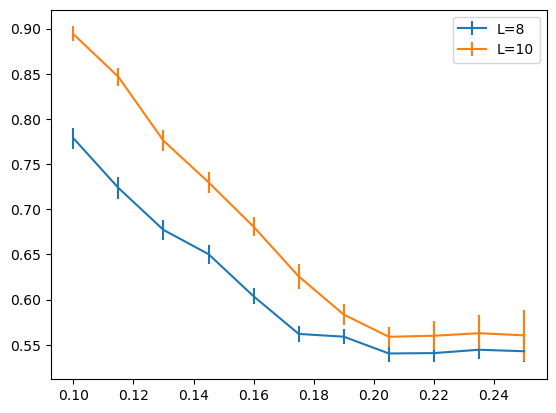

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_proj_list,Chi_mean_map[L_idx,0],yerr=Chi_se_map[L_idx,0],label=f'L={L}')
plt.legend()

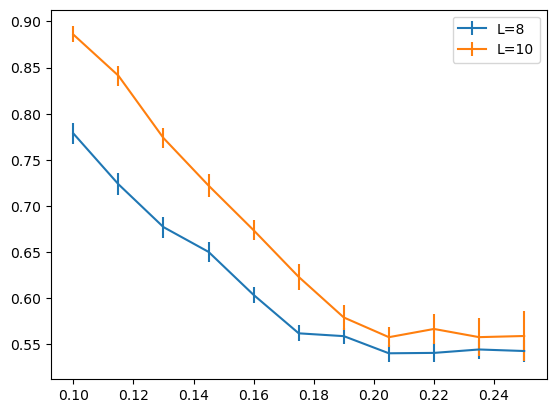

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_proj_list,Chi_mean_map[L_idx,0],yerr=Chi_se_map[L_idx,0],label=f'L={L}')
plt.legend()

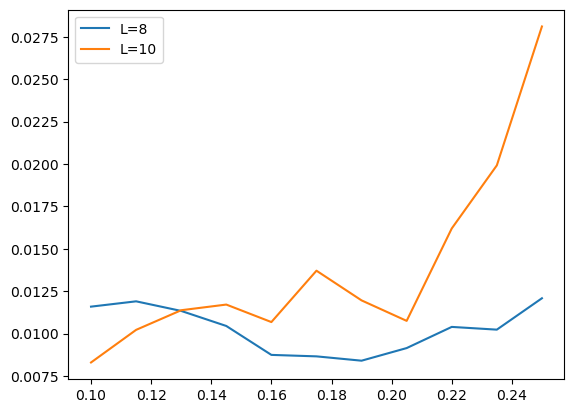

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_proj_list,Chi_se_map[L_idx,0],label=f'L={L}')
plt.legend()

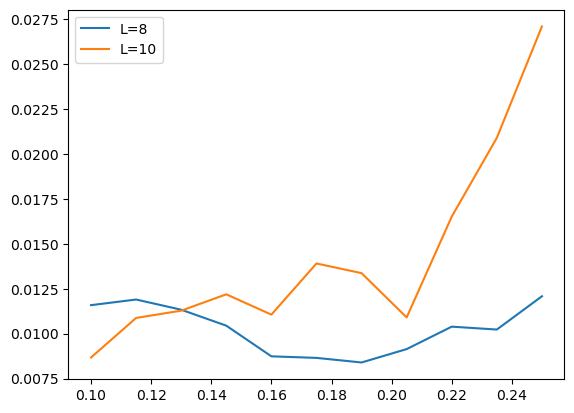

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_proj_list,Chi_se_map[L_idx,0],label=f'L={L}')
plt.legend()

### GPU

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def add_to_dict(data_dict,data,filename):
    if filename in data_dict['fn']:
        # print(f'File duplicated: {filename}' )
        pass
    else:
        data_dict['fn'].append(filename)
        L_list=np.arange(*data['args'].L)
        p_ctrl_list=np.round(np.linspace(data['args'].p_ctrl[0],data['args'].p_ctrl[1],int(data['args'].p_ctrl[2])),3)
        p_proj_list=np.round(np.linspace(data['args'].p_proj[0],data['args'].p_proj[1],int(data['args'].p_proj[2])),3)
        for key in set(data.keys())-set(['args']):
            for L_idx,L in enumerate(L_list):
                for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
                    for p_proj_idx,p_proj in enumerate(p_proj_list):
                            observations=data[key][L_idx,p_ctrl_idx,p_proj_idx]
                            if torch.is_tensor(observations):
                                # observations=observations.cpu().tolist()
                                observations=observations.cpu().numpy()
                            params=(key,L,p_ctrl,p_proj)
                            if params in data_dict:
                                # data_dict[params]=data_dict[params]+observations
                                data_dict[params]=np.r_[data_dict[params],observations]
                                # data_dict[params].append(observations)
                            else:
                                data_dict[params]=observations
                                # data_dict[params]=[observations]

In [ ]:
def add_to_dict_batch(s,p_ctrl_list,p_proj_list,en,L,xj,data_dict,anc=False):
    for s in range(s):
        for p_ctrl in p_ctrl_list:
            for p_proj in p_proj_list:
                # fn=f'CT_En{en}_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L({L},{L+2},2)_xj({xj})_seed{s}_64{"_anc"*anc}.pickle'
                fn=f'CT_En{en}_Enm2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L({L},{L+2},2)_xj({xj})_seed{s}_seedC{s}_64{"_anc"*anc}_XEB.pickle'
                try:
                    with open(fn,'rb') as f:
                    # with open(os.path.join('Data',fn),'rb') as f:
                        data=pickle.load(f)
                    add_to_dict(data_dict, data,fn)
                except:
                    print(f'File missing: {fn}')
            

In [ ]:
def convert_pd(data_dict):
    index = pd.MultiIndex.from_tuples([key for key in data_dict.keys() if key!='fn'], names=['Metrics','L', 'p_ctrl', 'p_proj'])
    df = pd.DataFrame({'observations': [val for key,val in data_dict.items() if key!='fn']}, index=index)
    return df

In [ ]:
d_dict={'fn':[]}
en={8:640,10:160,12:40}
s={8:1,10:16,12:3}
for L in [8,10,]:
    for seed in range(s[L]):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

for L in [12,]:
    for seed in range(32):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{14}_Enm8000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

for L in [10,]:
    for seed in range(16,44):
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

d2_dict={'fn':[]}
for L in [10,]:
    for seed in list(range(0,44)):
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed+1}_seedC{seed}_64_XEB.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d2_dict,save_dict,fn)

d3_dict={'fn':[]}
for L in [10,]:
    for seed in list(range(0,44)):
        try:
            fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed+2}_seedC{seed}_64_XEB.pickle'
            with open(fn,'rb') as f:
                save_dict=pickle.load(f)
            add_to_dict(d3_dict,save_dict,fn)
        except:
            print(f'File missing: {fn}')

for key, val in d2_dict.items(): 
    if key!='fn':
        d_dict[key]=np.c_[d_dict[key],val]
for key, val in d3_dict.items(): 
    if key!='fn':
        d_dict[key]=np.c_[d_dict[key],val]
d_pd=convert_pd(d_dict)

In [ ]:
d_encoding_dict={'fn':[]}
en={8:320,10:80,12:20}
s={8:1,10:8,12:8}
for L in [8,10,12]:
    for seed in range(s[L]):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_encoding_dict,save_dict,fn)
d_pd=convert_pd(d_encoding_dict)

In [ ]:
d_pctrl_encoding_dict={'fn':[]}
en={8:160,10:40,12:20}
s={8:2,10:8,12:8}
for L in [8,10]:
    for seed in range(s[L]):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.45,0.55,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_pctrl_encoding_dict,save_dict,fn)
d_pd=convert_pd(d_pctrl_encoding_dict)

In [ ]:
d_0_pctrl_encoding_dict={'fn':[]}
en={6:320,8:160,10:40,12:20,14:5}
s={6:1,8:4,10:32,12:64,14:27}
L_list=np.array([6,8,10,12,14])
for L in L_list:
    for seed in range(s[L]):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict,save_dict,fn)

d_0_pctrl_encoding_dict_2={'fn':[]}
for L in [12,]:
    for seed in list(range(64)):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed+1}_seedC{seed}_64_XEB_encoding.pickle'
        with open(fn,'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict_2,save_dict,fn)


for key, val in d_0_pctrl_encoding_dict_2.items(): 
    if key!='fn':
        d_0_pctrl_encoding_dict[key]=np.c_[d_0_pctrl_encoding_dict[key],val]
d_pd=convert_pd(d_0_pctrl_encoding_dict)

In [ ]:
def any_equal(key,d):
    for i in range(len(d)):
        for j in range(i+1,len(d)):
            if np.array_equal(d[i],d[j]):
                print(key,i,j)

In [ ]:
for key, val in d_dict.items():
    if key !='fn':
        any_equal(key,val)

In [ ]:
# d_pd=convert_pd(d_encoding_dict)
d_pd=convert_pd(d_pctrl_encoding_dict)

In [ ]:
len(d_pd.xs(key=12,level='L').xs(key=0.,level='p_ctrl').xs(key=0.22,level='p_proj').loc['log_q']['observations'])

160

In [ ]:
log_r__mat=d_pd.xs(key=10,level='L').xs(key=0.,level='p_ctrl').xs(key=0.25,level='p_proj').loc['log_r_']['observations']

In [ ]:
log_q_mat.std(axis=1)/log_q_mat.shape[1]**0.5

In [ ]:
log_r__mat

array([[-73.293915, -70.06846 , -71.550156, ..., -73.635765, -81.29699 ,
        -70.77766 ],
       [-73.57437 , -65.36156 , -67.08215 , ..., -66.00205 , -67.67549 ,
        -66.4272  ],
       [-64.79494 , -69.8257  , -63.68575 , ..., -65.47527 , -63.00931 ,
        -63.829285],
       ...,
       [-57.77272 , -59.193398, -56.139397, ..., -53.248722, -55.64927 ,
        -54.575817],
       [-65.56359 , -66.24649 , -64.942   , ..., -67.673935, -67.58412 ,
        -62.60302 ],
       [-62.490593, -65.57544 , -55.66983 , ..., -59.18539 , -59.108753,
        -60.543205]], dtype=float32)

In [ ]:
log_r__mat.shape

(7040, 6000)

In [ ]:
import scipy

In [ ]:
def logminusexp(a,b):
    assert a.shape==b.shape, f'shape mismatch: {a.shape} {b.shape}'
    assert np.all(a>=b), f'not all a>=b: {a} {b}'
    return a+np.log1p(-np.exp(b-a))

In [ ]:
def mean_std(data,axis=1,CV=False):
    ''' data is in log scale, and this compute the mean along axis 0 and the std along axis 1 by default'''
    r2m=scipy.special.logsumexp(2*data,axis=axis)-np.log(data.shape[axis])  # <r^2>
    rm2=2*(scipy.special.logsumexp(data,axis=axis)-np.log(data.shape[axis])) # <r>^2
    std=logminusexp(r2m, rm2)/2  # sqrt(<r^2>-<r>^2)
    if CV:
        mean=scipy.special.logsumexp(data,axis=axis)-np.log(data.shape[axis])
        std=std-mean
    mean=scipy.special.logsumexp(std)-np.log(std.shape[0])
    return mean

def std_mean(data,axis=1,CV=False):
    ''' data is in log scale, and this compute the mean along axis 1 and the std along axis 0 by default'''
    rm=scipy.special.logsumexp(data,axis=axis)-np.log(data.shape[axis]) # rm=<r>
    rm2m=scipy.special.logsumexp(2*rm,axis=0)-np.log(rm.shape[0])  # <rm^2> 
    rmm2=2*(scipy.special.logsumexp(rm,axis=0)-np.log(rm.shape[0]))  # <rm>^2 
    std=logminusexp(rm2m, rmm2)/2
    if CV:
        mean=scipy.special.logsumexp(rm,axis=0)-np.log(rm.shape[0])
        std=std-mean
    return std


In [ ]:
mean_std(data=log_r__mat)

-13.902527765739704

In [ ]:
std_mean(data=log_r__mat)

-11.542274323213643

In [ ]:
L_list=np.arange(8,14,2)
p_ctrl_list=np.round(np.linspace(0,0,1),2)
p_proj_list=np.round(np.linspace(0.1,0.25,11),3)

# p_ctrl_list=np.round(np.linspace(0.26,0.36,11),2)
# p_proj_list=np.round(np.linspace(0,0,1),3)


mean_std_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
std_mean_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
for L_idx,L in enumerate(L_list):
    for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
        for p_proj_idx,p_proj in enumerate(p_proj_list):
            log_r__mat=d_pd.xs(key=L,level='L').xs(key=p_ctrl,level='p_ctrl').xs(key=p_proj,level='p_proj').loc['log_r_']['observations']
            std_mean_map[L_idx,p_ctrl_idx,p_proj_idx]=std_mean(data=log_r__mat,CV=True)
            mean_std_map[L_idx,p_ctrl_idx,p_proj_idx]=mean_std(data=log_r__mat,CV=True)

Text(0.5, 0, '$p_{ctrl}$')

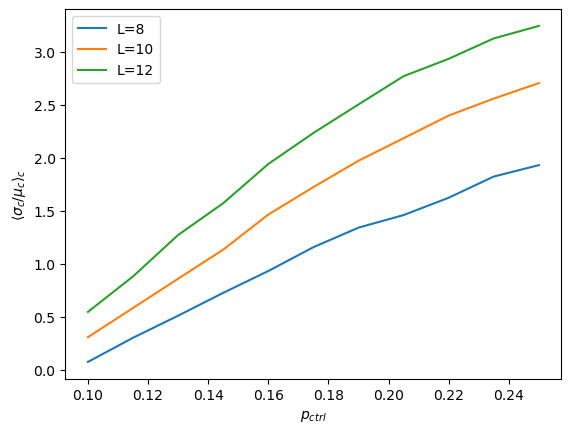

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_proj_list,mean_std_map[L_idx,0],label=f'L={L}')
plt.legend()
ax.set_ylabel(r'$\langle \sigma_c/\mu_c \rangle_c$')
ax.set_xlabel(r'$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

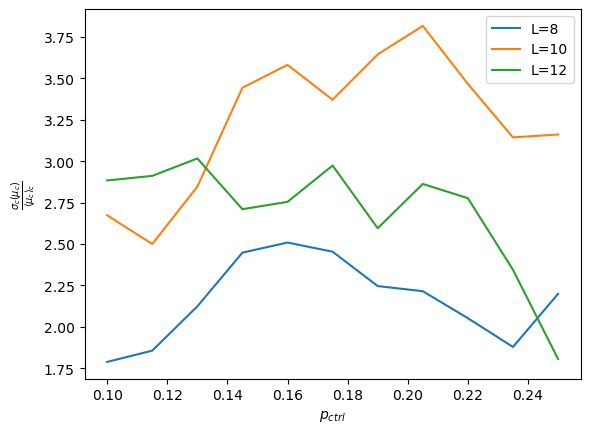

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_proj_list,std_mean_map[L_idx,0],label=f'L={L}')
plt.legend()
ax.set_ylabel(r'$\frac{\sigma_c(\mu_c)}{\langle\mu_c\rangle_c}$')
ax.set_xlabel(r'$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

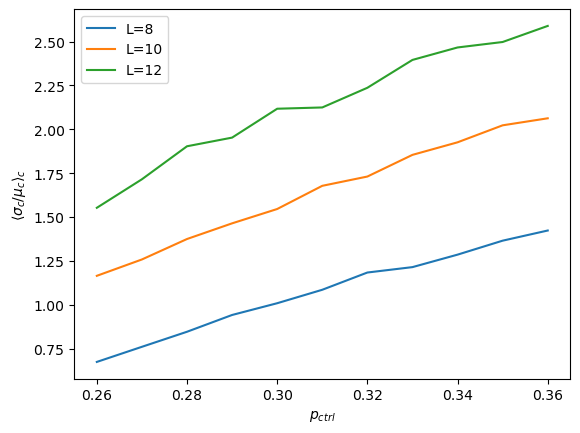

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_ctrl_list,mean_std_map[L_idx,:,0],label=f'L={L}')
ax.legend()
ax.set_ylabel(r'$\langle \sigma_c/\mu_c \rangle_c$')
ax.set_xlabel(r'$p_{ctrl}$')

Text(0.5, 0, '$p_{ctrl}$')

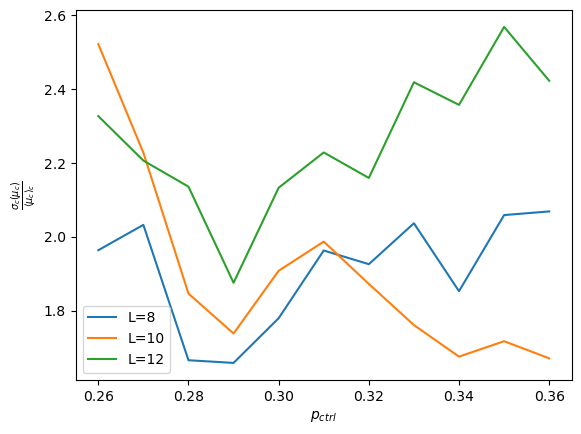

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_ctrl_list,std_mean_map[L_idx,:,0],label=f'L={L}')
plt.legend()
ax.set_ylabel(r'$\frac{\sigma_c(\mu_c)}{\langle\mu_c\rangle_c}$')
ax.set_xlabel(r'$p_{ctrl}$')

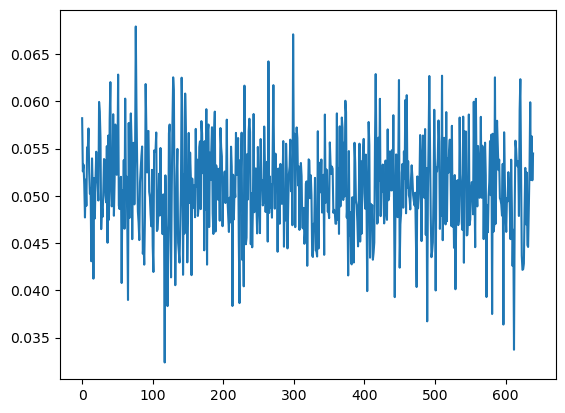

In [ ]:
plt.plot(log_r_mat.std(axis=1)/log_r_mat.shape[1]**0.5)
# plt.plot(log_r__mat.std(axis=1)/log_r_mat.shape[1]**0.5)

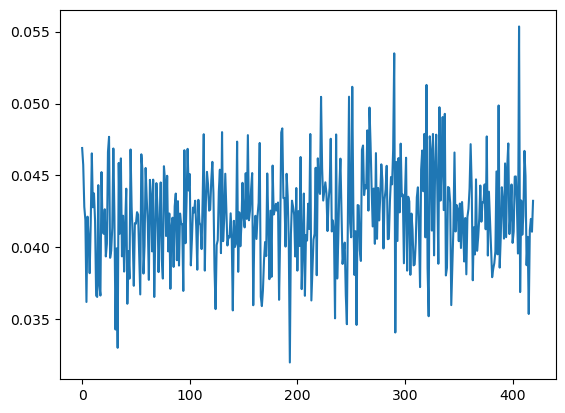

In [ ]:
plt.plot(log_q_mat.std(axis=1)/log_q_mat.shape[1]**0.5)

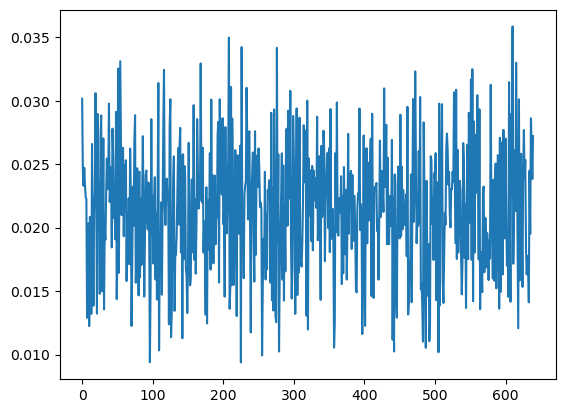

In [ ]:
plt.plot(log_q_mat.std(axis=1)/log_q_mat.shape[1]**0.5)

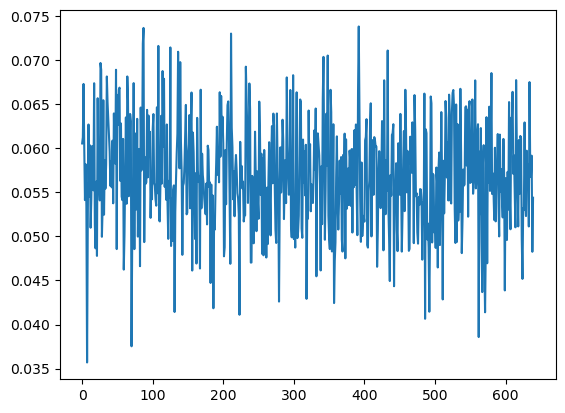

In [ ]:
plt.plot(log_q_mat.std(axis=1)/log_q_mat.shape[1]**0.5)

In [ ]:
def sample_Born_tensor(log_p_r,log_p_r_):
    return torch.exp(torch.logsumexp(log_p_r,dim=1)-torch.logsumexp(log_p_r_,dim=1))

In [ ]:
def Chi_(d_pd,p_ctrl_list,p_proj_list,L_list,N_C=None,N_m=None):
    Chi_se_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
    Chi_mean_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
    for L_idx,L in enumerate(L_list):
        for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
            for p_proj_idx,p_proj in enumerate(p_proj_list):
                d_pd_tmp=d_pd.xs(key=L,level='L').xs(key=p_ctrl,level='p_ctrl').xs(key=p_proj,level='p_proj')
                log_r=torch.tensor(d_pd_tmp.loc['log_r']['observations'])
                log_r_=torch.tensor(d_pd_tmp.loc['log_r_']['observations'])
                if N_C is not None:
                    indices = torch.randint(0, log_r.shape[0], (N_C,))
                    log_r=log_r[indices]
                    log_r_=log_r_[indices]
                if N_m is not None:
                    indices = torch.randint(0, log_r_.shape[1], (N_m,))
                    log_r=log_r[:,indices]
                    log_r_=log_r_[:,indices]
                Chi_mean_map[L_idx,p_ctrl_idx,p_proj_idx]=sample_Born_tensor(log_r,log_r_).mean()
                Chi_se_map[L_idx,p_ctrl_idx,p_proj_idx]=sample_Born_tensor(log_r,log_r_).std()/np.sqrt(len(d_pd_tmp.loc['log_r'][0]))
    return Chi_mean_map,Chi_se_map

In [ ]:
# L_list=np.arange(8,10,2)
# p_ctrl_list=np.round(np.linspace(0,0,1),2)
# p_proj_list=np.round(np.linspace(0.1,0.25,11),3)

# p_ctrl_list=np.round(np.linspace(0.45,0.55,11),2)
# p_proj_list=np.round(np.linspace(0,0,1),3)






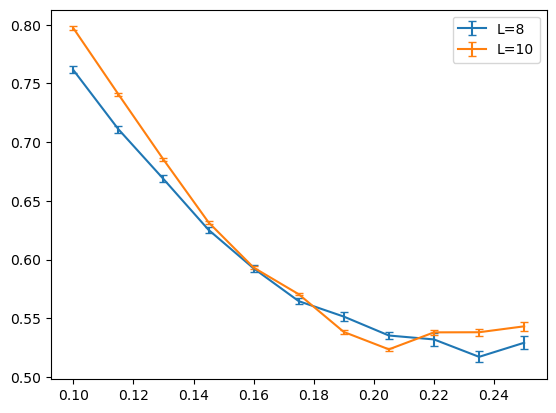

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list[:]):
    ax.errorbar(p_proj_list,Chi_mean_map[L_idx,0],yerr=Chi_se_map[L_idx,0],label=f'L={L}',capsize=3)
plt.legend()

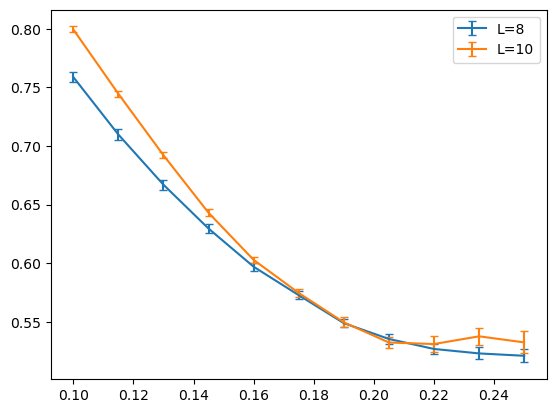

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_proj_list,Chi_mean_map[L_idx,0],yerr=Chi_se_map[L_idx,0],label=f'L={L}',capsize=3)
plt.legend()

In [ ]:
p_ctrl_list

array([0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55])

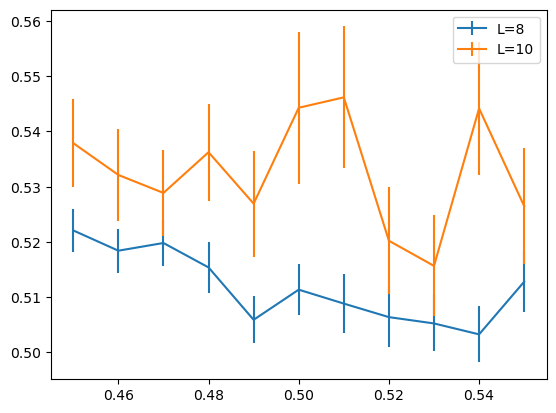

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_ctrl_list,Chi_mean_map[L_idx,:,0],yerr=Chi_se_map[L_idx,:,0],label=f'L={L}')
plt.legend()

In [ ]:
from tqdm import  tqdm

In [ ]:
p_ctrl_list=np.round(np.linspace(0.26,0.36,11),2)
p_proj_list=np.round(np.linspace(0,0,1),3)
Chi_mean_map,Chi_se_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list)
# Chi_mean_2_map,Chi_se_2_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list,N_C=400,N_m=None)

# bootstrapsize=1000
# Chi_mean_2_tensor=np.zeros((bootstrapsize,*Chi_mean_map.shape))
# Chi_se_2_tensor=np.zeros((bootstrapsize,*Chi_mean_map.shape))
# for idx in tqdm(range(bootstrapsize)):
#     Chi_mean_2_tensor[idx],Chi_se_2_tensor[idx]=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list,N_C=240,N_m=3000)

Text(0, 0.5, '$\\sigma_\\chi$')

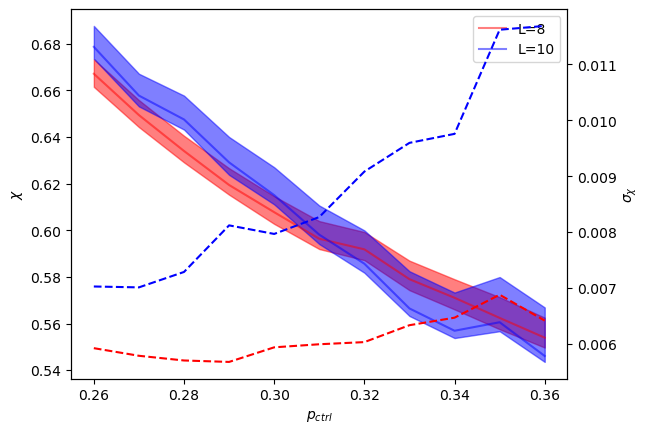

In [ ]:
fig,ax=plt.subplots()
color_list=['r','b','g','k']
ax2=ax.twinx()
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_ctrl_list,Chi_mean_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx],alpha=0.5,ls='solid')
    ax.fill_between(p_ctrl_list,Chi_mean_2_tensor.mean(axis=0)[L_idx,:,0]-Chi_mean_2_tensor.std(axis=0)[L_idx,:,0],Chi_mean_2_tensor.mean(axis=0)[L_idx,:,0]+Chi_mean_2_tensor.std(axis=0)[L_idx,:,0],alpha=0.5,color=color_list[L_idx],)
    # yerr=Chi_se_map[L_idx,:,0],
    # ax.errorbar(p_ctrl_list,Chi_mean_2_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx],)
    # yerr=Chi_se_2_map[L_idx,:,0],
    ax2.plot(p_ctrl_list,Chi_mean_2_tensor.std(axis=0)[L_idx,:,0],color=color_list[L_idx],ls='dashed')
ax.legend()
ax.set_ylabel(r'$\chi$')
ax.set_xlabel(r'$p_{ctrl}$')
ax2.set_ylabel(r'$\sigma_\chi$')

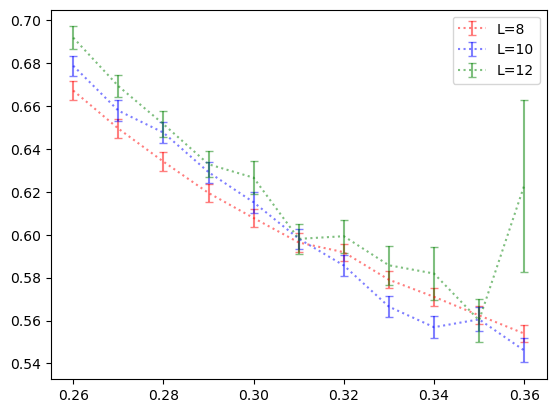

In [ ]:
fig,ax=plt.subplots()
color_list=['r','b','g','k']
for L_idx,L in enumerate(L_list):
    ax.errorbar(p_ctrl_list,Chi_mean_map[L_idx,:,0],yerr=Chi_se_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx])
    # ax.errorbar(p_ctrl_list,Chi_mean_2_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx],)
    # yerr=Chi_se_2_map[L_idx,:,0],
plt.legend()

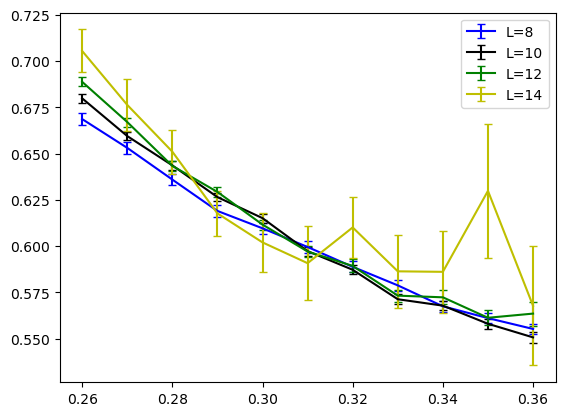

In [ ]:
fig,ax=plt.subplots()
color_list=['r','b','k','g','y']
for L_idx,L in enumerate(L_list[:]):
    if L>6:
        ax.errorbar(p_ctrl_list,Chi_mean_map[L_idx,:,0],yerr=Chi_se_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx])
plt.legend()

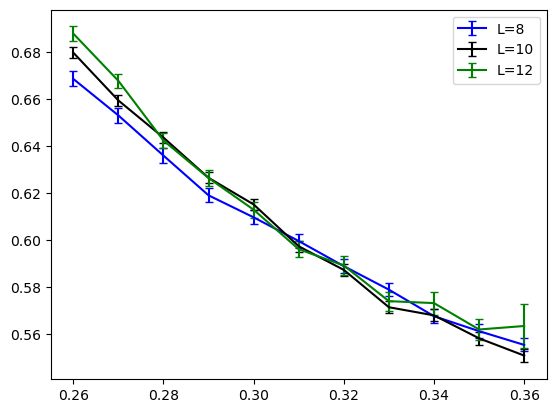

In [ ]:
fig,ax=plt.subplots()
color_list=['r','b','k','g']
for L_idx,L in enumerate(L_list[:]):
    if L>6:
        ax.errorbar(p_ctrl_list,Chi_mean_map[L_idx,:,0],yerr=Chi_se_map[L_idx,:,0],label=f'L={L}',capsize=3,color=color_list[L_idx])
plt.legend()

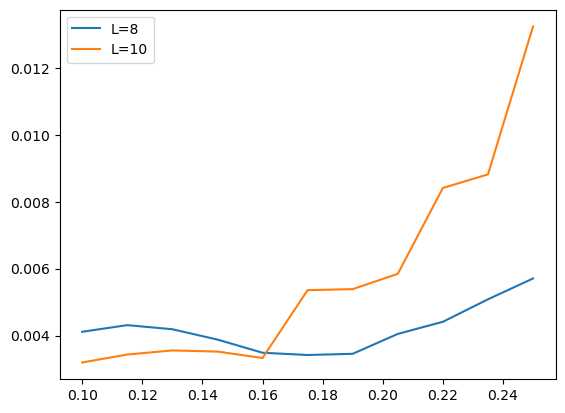

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_proj_list,Chi_se_map[L_idx,0],label=f'L={L}')
plt.legend()

In [ ]:
np.linspace(0.1,0.25,11)

array([0.1  , 0.115, 0.13 , 0.145, 0.16 , 0.175, 0.19 , 0.205, 0.22 ,
       0.235, 0.25 ])

In [ ]:
np.linspace(0.19,0.25,5)

array([0.19 , 0.205, 0.22 , 0.235, 0.25 ])

In [ ]:
Chi=[torch.mean(sample_Born_tensor(save_dict_8['log_r'][0,0,idx],save_dict_8['log_r_'][0,0,idx])) for idx in range(save_dict_8['log_q'].shape[2])]
Chi_std=[torch.std(sample_Born_tensor(save_dict_8['log_r'][0,0,idx],save_dict_8['log_r_'][0,0,idx]))/np.sqrt(save_dict_8['log_q'].shape[-1]) for idx in range(save_dict_8['log_q'].shape[2])]

In [ ]:
Chi

[tensor(0.7641),
 tensor(0.7198),
 tensor(0.6788),
 tensor(0.6456),
 tensor(0.6199),
 tensor(0.5989),
 tensor(0.5982),
 tensor(0.5925),
 tensor(0.6026),
 tensor(0.6060),
 tensor(0.6442)]

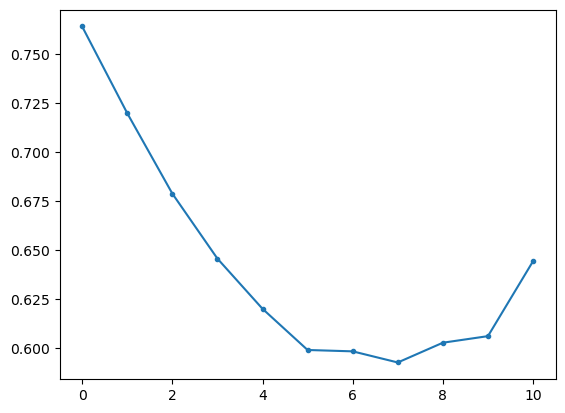

In [ ]:
plt.plot(Chi,'.-')


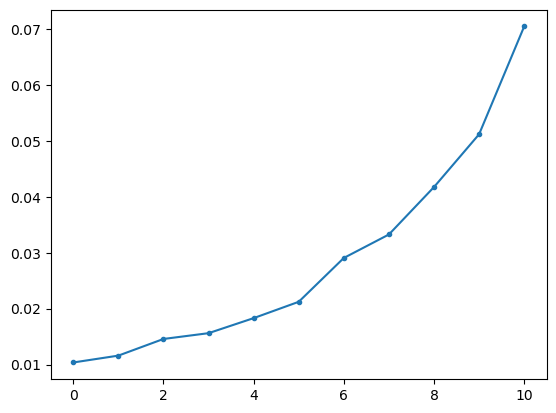

In [ ]:
plt.plot(Chi_std,'.-')

### Regular

In [ ]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0],seed_C_list.shape[0],seed_list.shape[0],3))
log_p_q,log_p_r,log_p_r_=rs[...,0],rs[...,1],rs[...,2]

In [ ]:
log_p_q.shape

(3, 1, 11, 30, 3200)

In [ ]:
np.logaddexp

In [ ]:
def inner_prob(log_p_r_):
    log_p_r_2=scipy.special.logsumexp((log_p_r_))-np.log(log_p_r_.shape[0])
    return log_p_r_2

In [ ]:
inner_prob(log_p_r_[0,0,3,1])

-23.485888070616852

In [ ]:
log_p_r_.shape

(3, 1, 11, 30, 3200)

0.31386897967948707

In [ ]:
def sample_Born(log_p_r,log_p_r_):
    log_p_r_2=scipy.special.logsumexp((log_p_r_))-np.log(log_p_r_.shape[0])
    return np.exp(scipy.special.logsumexp(log_p_r)-log_p_r_2-np.log(log_p_r.shape[0]))

In [ ]:
def sample_Born_2(log_p_r,log_p_r_):
    return np.exp(scipy.special.logsumexp(log_p_r)-scipy.special.logsumexp(log_p_r_))

In [ ]:
Chi_C=[sample_Born(log_p_r_C, log_p_r__C) for log_p_r_C,log_p_r__C in zip(log_p_r[0],log_p_r_[0])]

In [ ]:
Chi_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
for L_idx,L in enumerate(L_list):
    for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
        for p_proj_idx,p_proj in enumerate(p_proj_list):
            # Chi_map[L_idx,p_ctrl_idx,p_proj_idx]=np.mean([sample_Born(log_p_r[L_idx,p_ctrl_idx,p_proj_idx,C_idx], log_p_r_[L_idx,p_ctrl_idx,p_proj_idx,C_idx]) for C_idx in range(seed_C_list.shape[0])])
            # Chi_map[L_idx,p_ctrl_idx,p_proj_idx]=np.std([sample_Born(log_p_r[L_idx,p_ctrl_idx,p_proj_idx,C_idx], log_p_r_[L_idx,p_ctrl_idx,p_proj_idx,C_idx]) for C_idx in range(seed_C_list.shape[0])])
            Chi_map[L_idx,p_ctrl_idx,p_proj_idx]=np.std([scipy.special.logsumexp(2*log_p_r_[L_idx,p_ctrl_idx,p_proj_idx,idx,:])-2*scipy.special.logsumexp(log_p_r_[L_idx,p_ctrl_idx,p_proj_idx,idx,:]) for idx in range(30)])


In [ ]:
Chi_map.shape

(3, 1, 11)

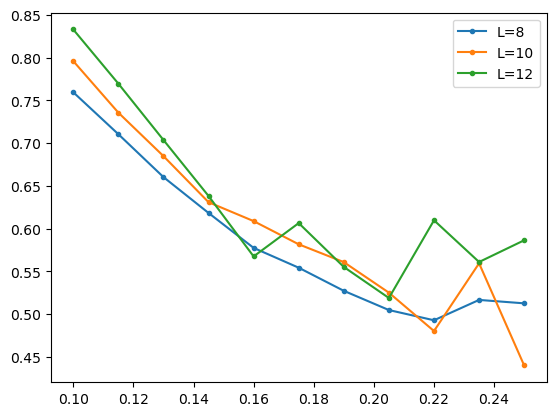

In [ ]:
for L_idx,L in enumerate(L_list):
    plt.plot(p_proj_list,Chi_map[L_idx,0],'.-',label=f'L={L}')
plt.legend()

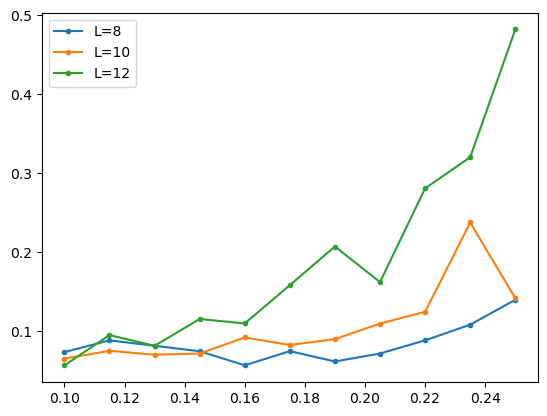

In [ ]:
for L_idx,L in enumerate(L_list):
    plt.plot(p_proj_list,Chi_map[L_idx,0],'.-',label=f'L={L}')
plt.legend()

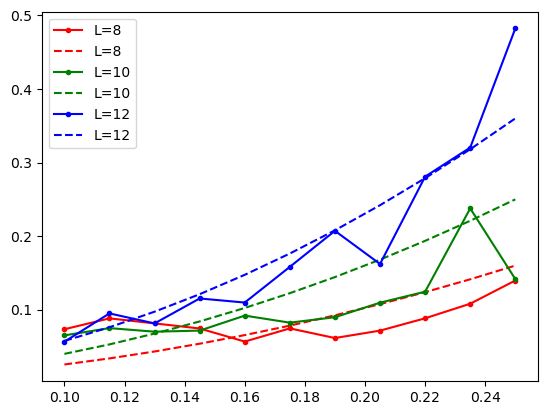

In [ ]:
color_list='rgb'
for (L_idx,L),color in zip(enumerate(L_list),color_list):
    plt.plot((p_proj_list),(Chi_map[L_idx,0]),'.-',label=f'L={L}',color=color)
    y=L**2*p_proj_list**2/25
    plt.plot(p_proj_list,y,'--',label=f'L={L}',color=color)
plt.legend()

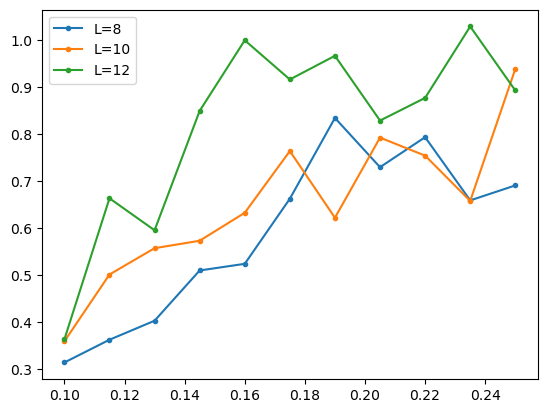

In [ ]:
for L_idx,L in enumerate(L_list):
    plt.plot(p_proj_list,Chi_map[L_idx,0],'.-',label=f'L={L}')
plt.legend()

In [ ]:
np.mean(Chi_C)

0.5183113097948199

#### Incorrect

In [ ]:
def Chi(logp_q,logp_r):
    logp_qr=logp_q+logp_r # p_qr = p_q* p_r
    logp_rr=2*logp_r # p_r*2
    return np.exp(scipy.special.logsumexp(logp_qr)-scipy.special.logsumexp(logp_rr))

In [ ]:
Chi_C=[Chi((logp_q_C),(logp_r_C)) for logp_q_C,logp_r_C in zip(log_p_q[0],log_p_r[0])]

In [ ]:
Chi_C

In [ ]:
np.mean(Chi_C)

1.1754662336941928

In [ ]:
np.mean(Chi_C)

1.041857250031049

In [ ]:
np.mean(Chi_C)

1.007867984638609